In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Download CO2 data from NOAA
url = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'

names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(url, skiprows=72, names=names, index_col=False)

In [3]:
df

year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0    1960     10     1960.7896   313.83          316.83     -1 -9.99 -0.99
1    1960     11     1960.8743   315.00          316.88     -1 -9.99 -0.99
2    1960     12     1960.9563   316.19          316.96     -1 -9.99 -0.99
3    1961      1     1961.0411   316.89          316.86     -1 -9.99 -0.99
4    1961      2     1961.1260   317.70          317.08     -1 -9.99 -0.99
..    ...    ...           ...      ...             ...    ...   ...   ...
754  2023      8     2023.6250   419.68          421.57     21  0.45  0.19
755  2023      9     2023.7083   418.51          421.96     18  0.30  0.14
756  2023     10     2023.7917   418.82          422.11     27  0.47  0.17
757  2023     11     2023.8750   420.46          422.43     21  0.91  0.38
758  2023     12     2023.9583   421.86          422.58     20  0.69  0.29

[759 rows x 8 columns]

In [4]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

<Axes: title={'center': 'CO2 Levels at Mauna Loa Observatory'}>

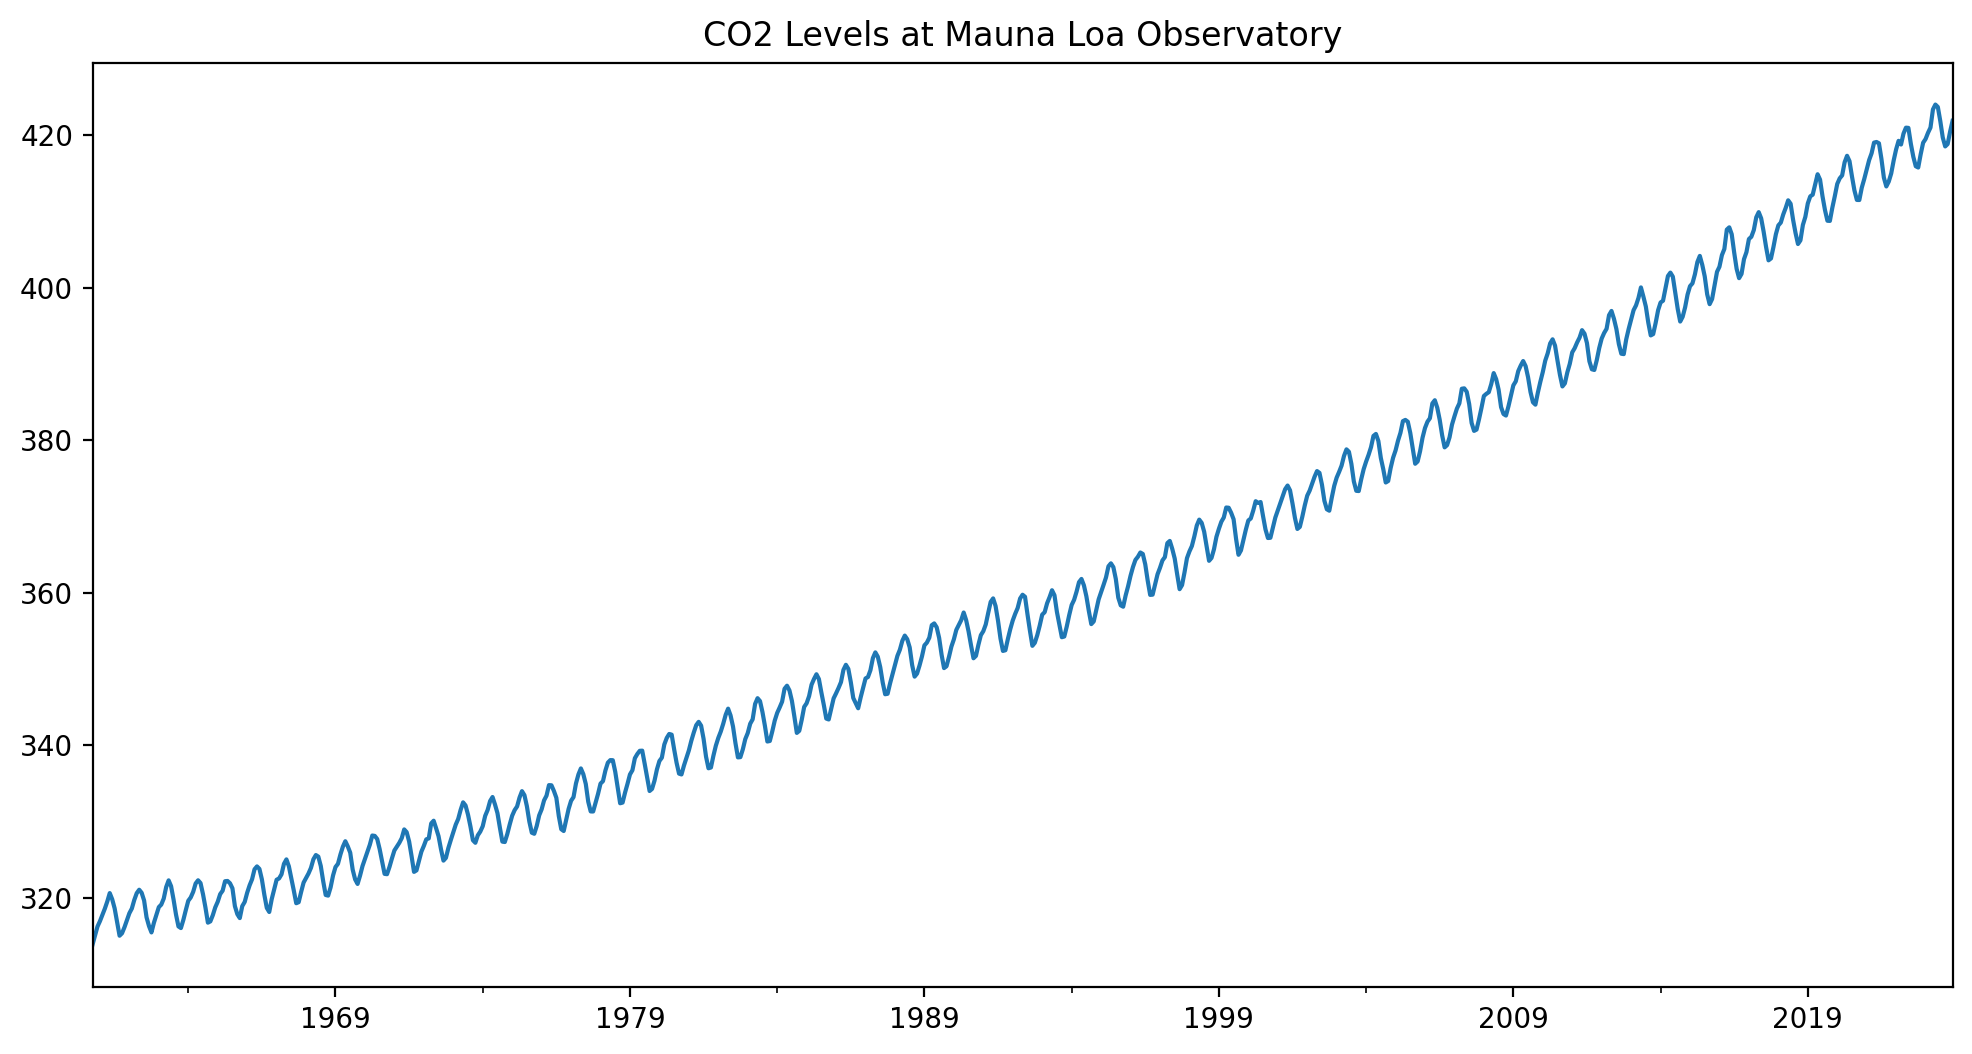

In [5]:
df.average.plot(figsize=(12, 6), title='CO2 Levels at Mauna Loa Observatory')

In [6]:
# Create X and y

# X = months since first measurement
X = np.array(range(len(df)))
y = df.average.values

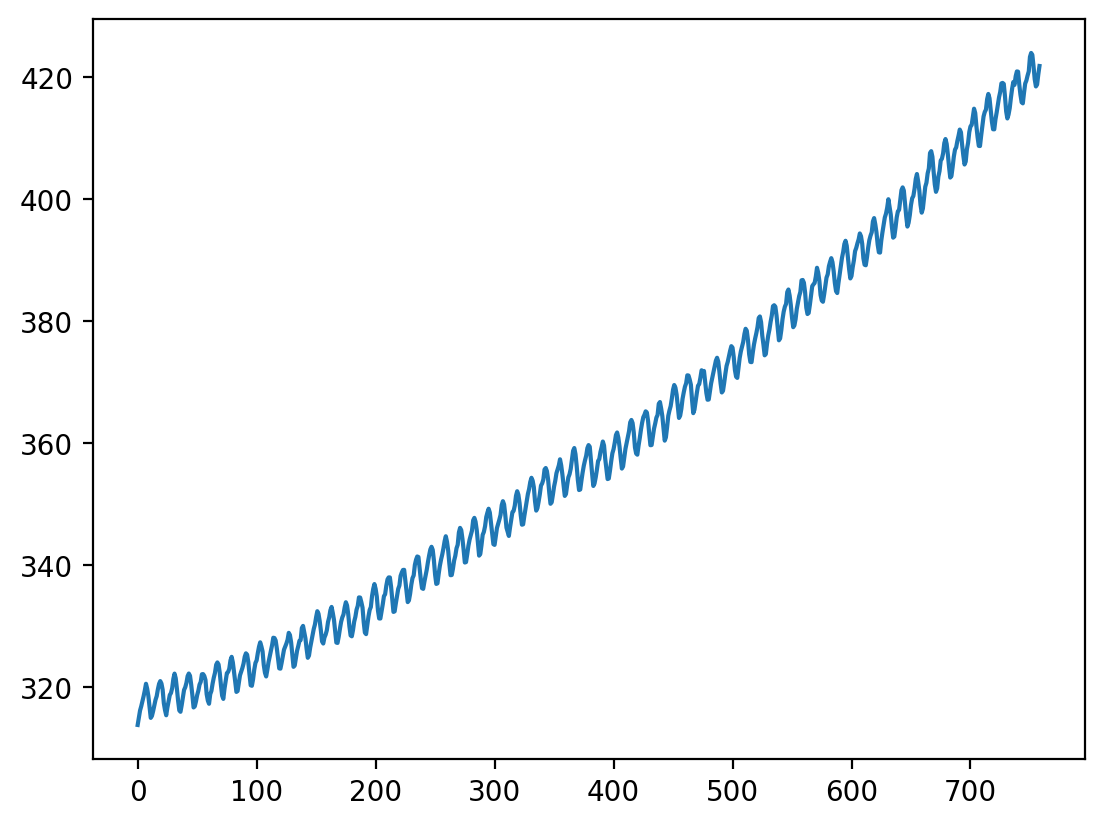

In [7]:
plt.plot(X, y)

In [8]:
# Normalize X and y

s1 = StandardScaler()
s2 = StandardScaler()

X_norm = s1.fit_transform(X.reshape(-1, 1))
y_norm = s2.fit_transform(y.reshape(-1, 1))

In [9]:
X_norm.mean(), X_norm.std()

(0.0, 1.0)

In [10]:
y_norm.mean(), y_norm.std()

(1.647635329298783e-15, 1.0)

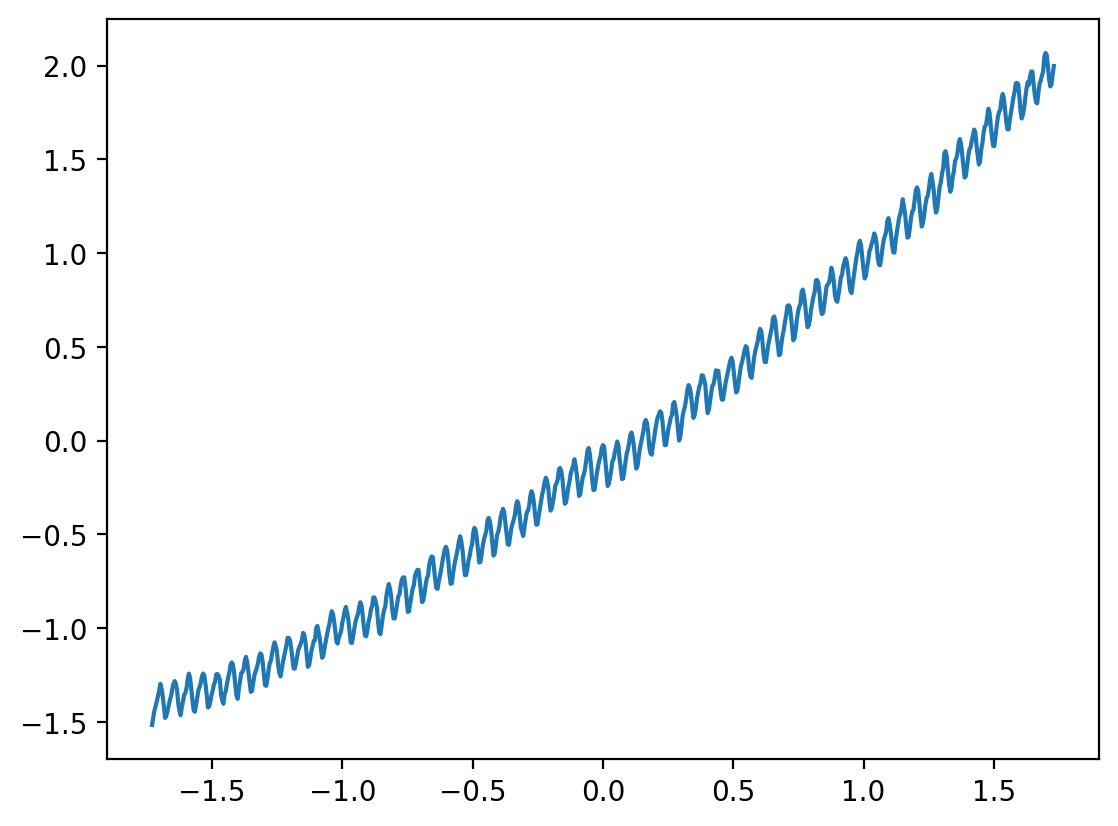

In [11]:
plt.plot(X_norm, y_norm)

#### Task 1: Interpolation

In [12]:
np.random.seed(42)
train_idx = np.random.choice(range(len(X_norm)), size=int(len(X_norm) * 0.7), replace=False)
test_idx = list(set(range(len(X_norm))) - set(train_idx))

X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

X_norm_train = X_norm[train_idx]
y_norm_train = y_norm[train_idx]

X_norm_test = X_norm[test_idx]
y_norm_test = y_norm[test_idx]

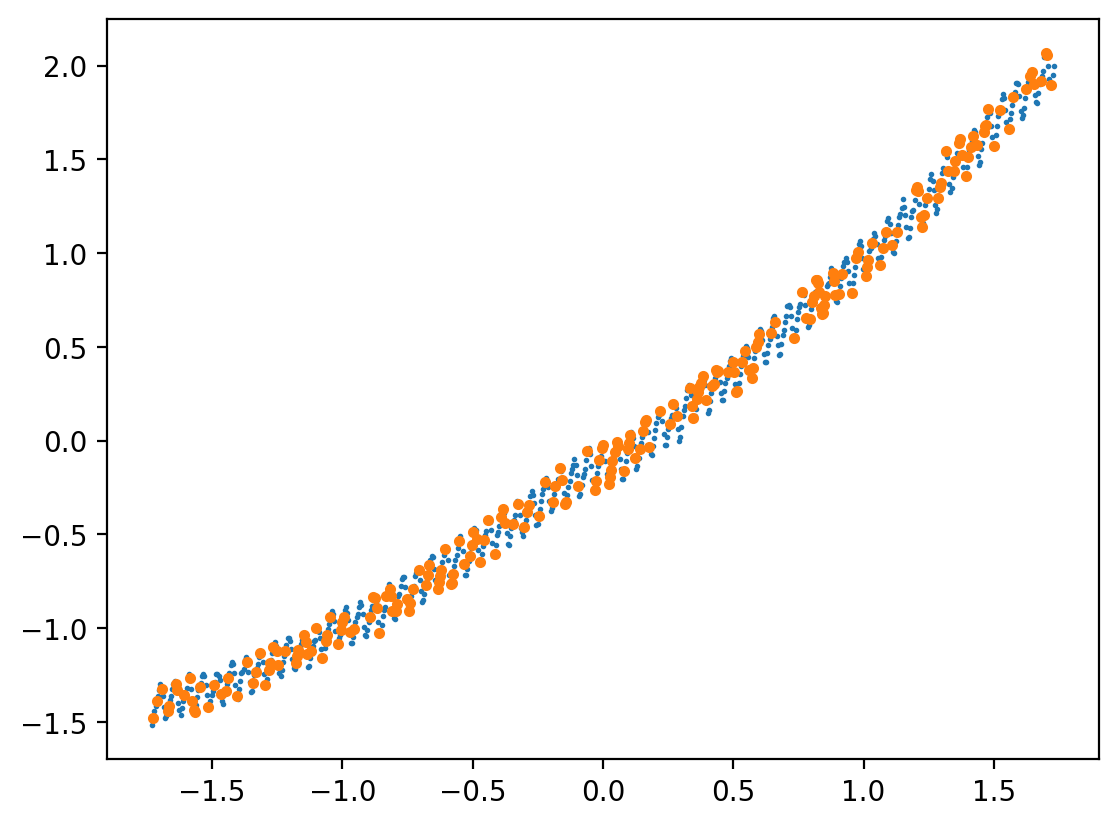

In [13]:
plt.plot(X_norm_train, y_norm_train, 'o', label='train',markersize=1)
plt.plot(X_norm_test, y_norm_test, 'o', label='test', ms=3)

In [14]:
errors= {}
X_lin_1d = np.linspace(X_norm.min(), X_norm.max(), 100).reshape(-1, 1)

### Model 1: Vanilla Linear Regression

In [15]:
def plot_fit_predict(model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin, title, plot=True):
    model.fit(X_norm_train, y_norm_train)

    y_hat_train = model.predict(X_norm_train).reshape(-1, 1)
    y_hat_test = model.predict(X_norm_test).reshape(-1, 1)

    # Transform back to original scale
    y_hat_train = s2.inverse_transform(y_hat_train)
    y_hat_test = s2.inverse_transform(y_hat_test)

    y_hat_lin = s2.inverse_transform(model.predict(X_lin).reshape(-1, 1))

    errors[title] = {"train": mean_squared_error(y_train, y_hat_train),
                     "test": mean_squared_error(y_test, y_hat_test)}

    if plot:
        plt.plot(X_train, y_train, 'o', label='train', markersize=1)
        plt.plot(X_test, y_test, 'o', label='test', ms=3)
        plt.plot(s1.inverse_transform(X_lin_1d), y_hat_lin, label='model')
        plt.xlabel('Months since first measurement')
        plt.ylabel('CO2 Levels')
        plt.legend()
        plt.title('{}\n Train MSE: {:.2f} | Test MSE: {:.2f}'.format(title, errors[title]["train"], errors[title]["test"]))

    return errors[title]

{'train': 20.261366262795637, 'test': 19.199721859759357}

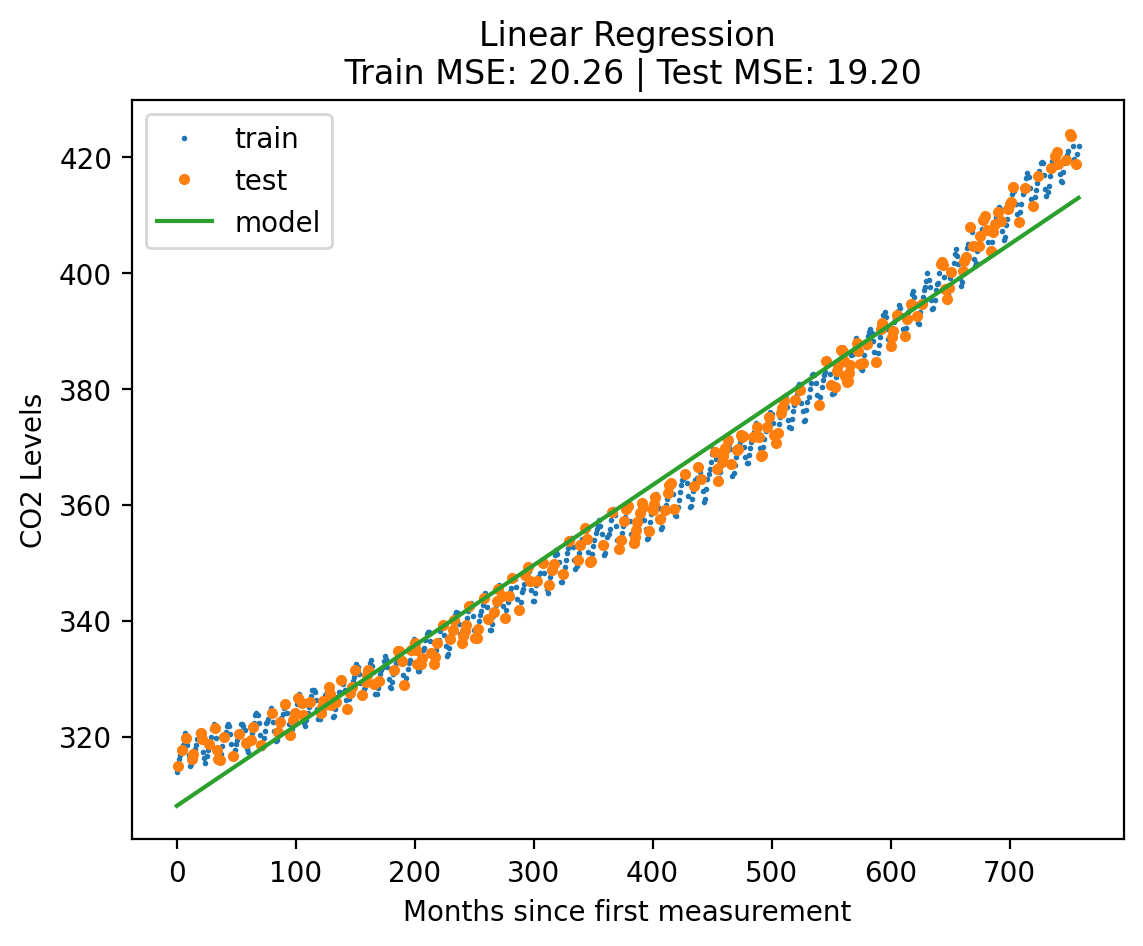

In [16]:
model = LinearRegression()
plot_fit_predict(model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "Linear Regression")

### MLP

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'train': 4.752028323119782, 'test': 4.665698336426401}

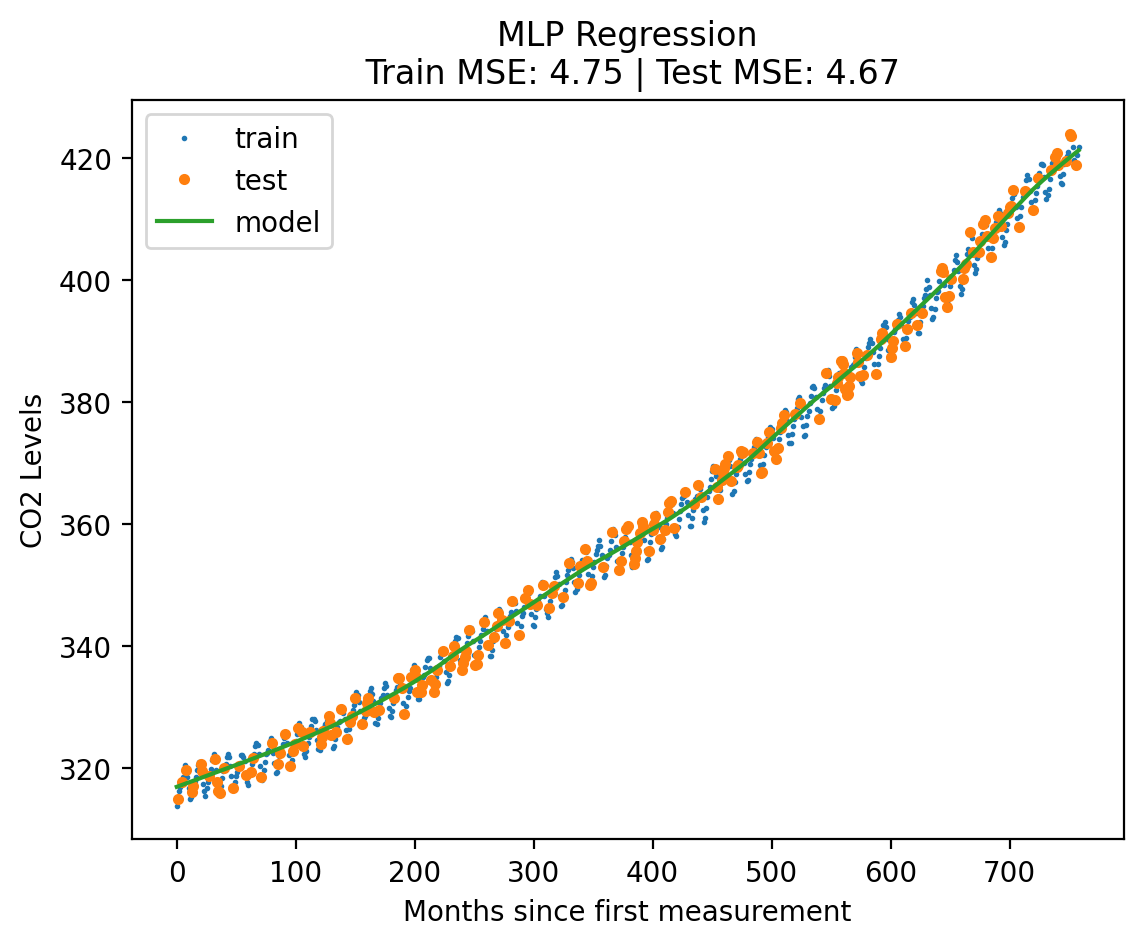

In [17]:
# use sk-learn for MLP
mlp_model = MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter = 10000)

plot_fit_predict(mlp_model, X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "MLP Regression")

### Polynomial Regression of degree "d"

In [18]:
def create_poly_features(X, d):
    """
    X is (N, 1) array
    d is degree of polynomial
    returns normalized polynomial features of X
    """
    
    X_poly = np.zeros((len(X), d))
    for i in range(d):
        X_poly[:, i] = X[:, 0] ** (i + 1)
    
    # Normalize each column
    X_poly = StandardScaler().fit_transform(X_poly)
    return X_poly

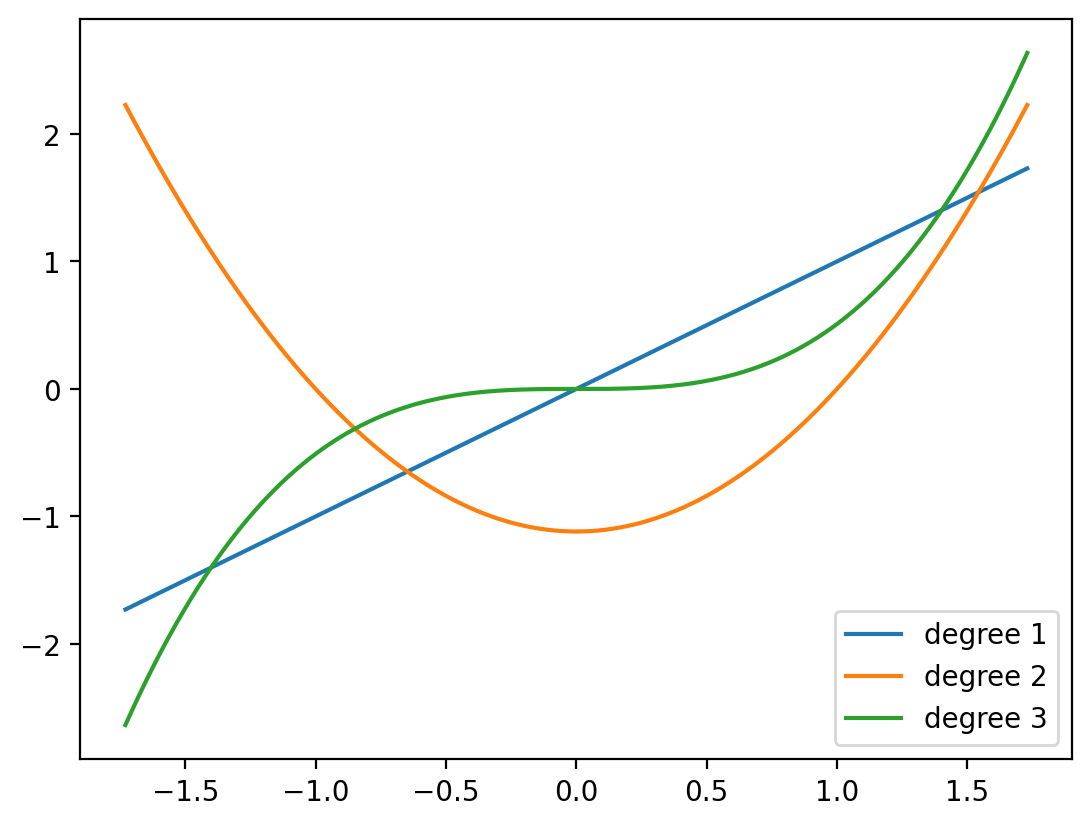

In [19]:
degree = 3
X_poly = create_poly_features(X_norm, degree)
for i in range(degree):
    plt.plot(X_norm, X_poly[:, i], label='degree {}'.format(i + 1))
plt.legend()

{'train': 4.9569848077348295, 'test': 6.37434206173535}

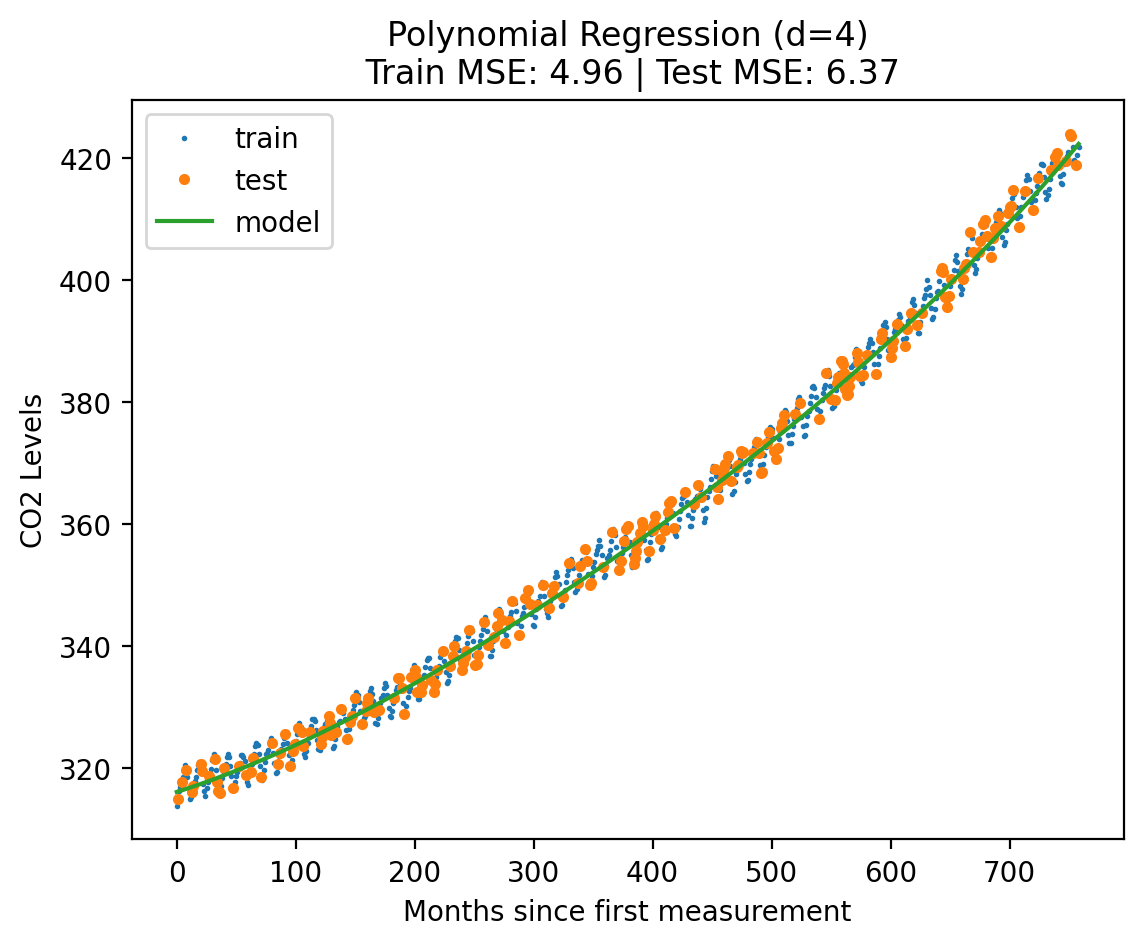

In [20]:
model2 = LinearRegression()
degree = 4
Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)
X_lin_poly = create_poly_features(X_lin_1d, degree)

plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Polynomial Regression (d={degree})")

In [21]:
model2.coef_, model2.intercept_

(array([[0.97834069, 0.09963612, 0.01969948, 0.0283343 ]]),
 array([-0.01122412]))

In [22]:
for degree in range(1, 10):
    Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_poly_features(X_lin_1d, degree)

    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Polynomial Regression (d={degree})", plot=False)

In [23]:
errors_df = pd.DataFrame(errors).T
errors_df

train       test
Linear Regression            20.261366  19.199722
MLP Regression                4.752028   4.665698
Polynomial Regression (d=4)   4.956985   6.374342
Polynomial Regression (d=1)  20.261366  20.851623
Polynomial Regression (d=2)   5.075907   6.678665
Polynomial Regression (d=3)   5.017752   6.567621
Polynomial Regression (d=5)   4.816000   6.407422
Polynomial Regression (d=6)   4.805097   6.390612
Polynomial Regression (d=7)   4.767340   6.491631
Polynomial Regression (d=8)   4.750171   6.508795
Polynomial Regression (d=9)   4.683092   6.514263

<Axes: title={'center': 'MSE for Train and Test Sets'}>

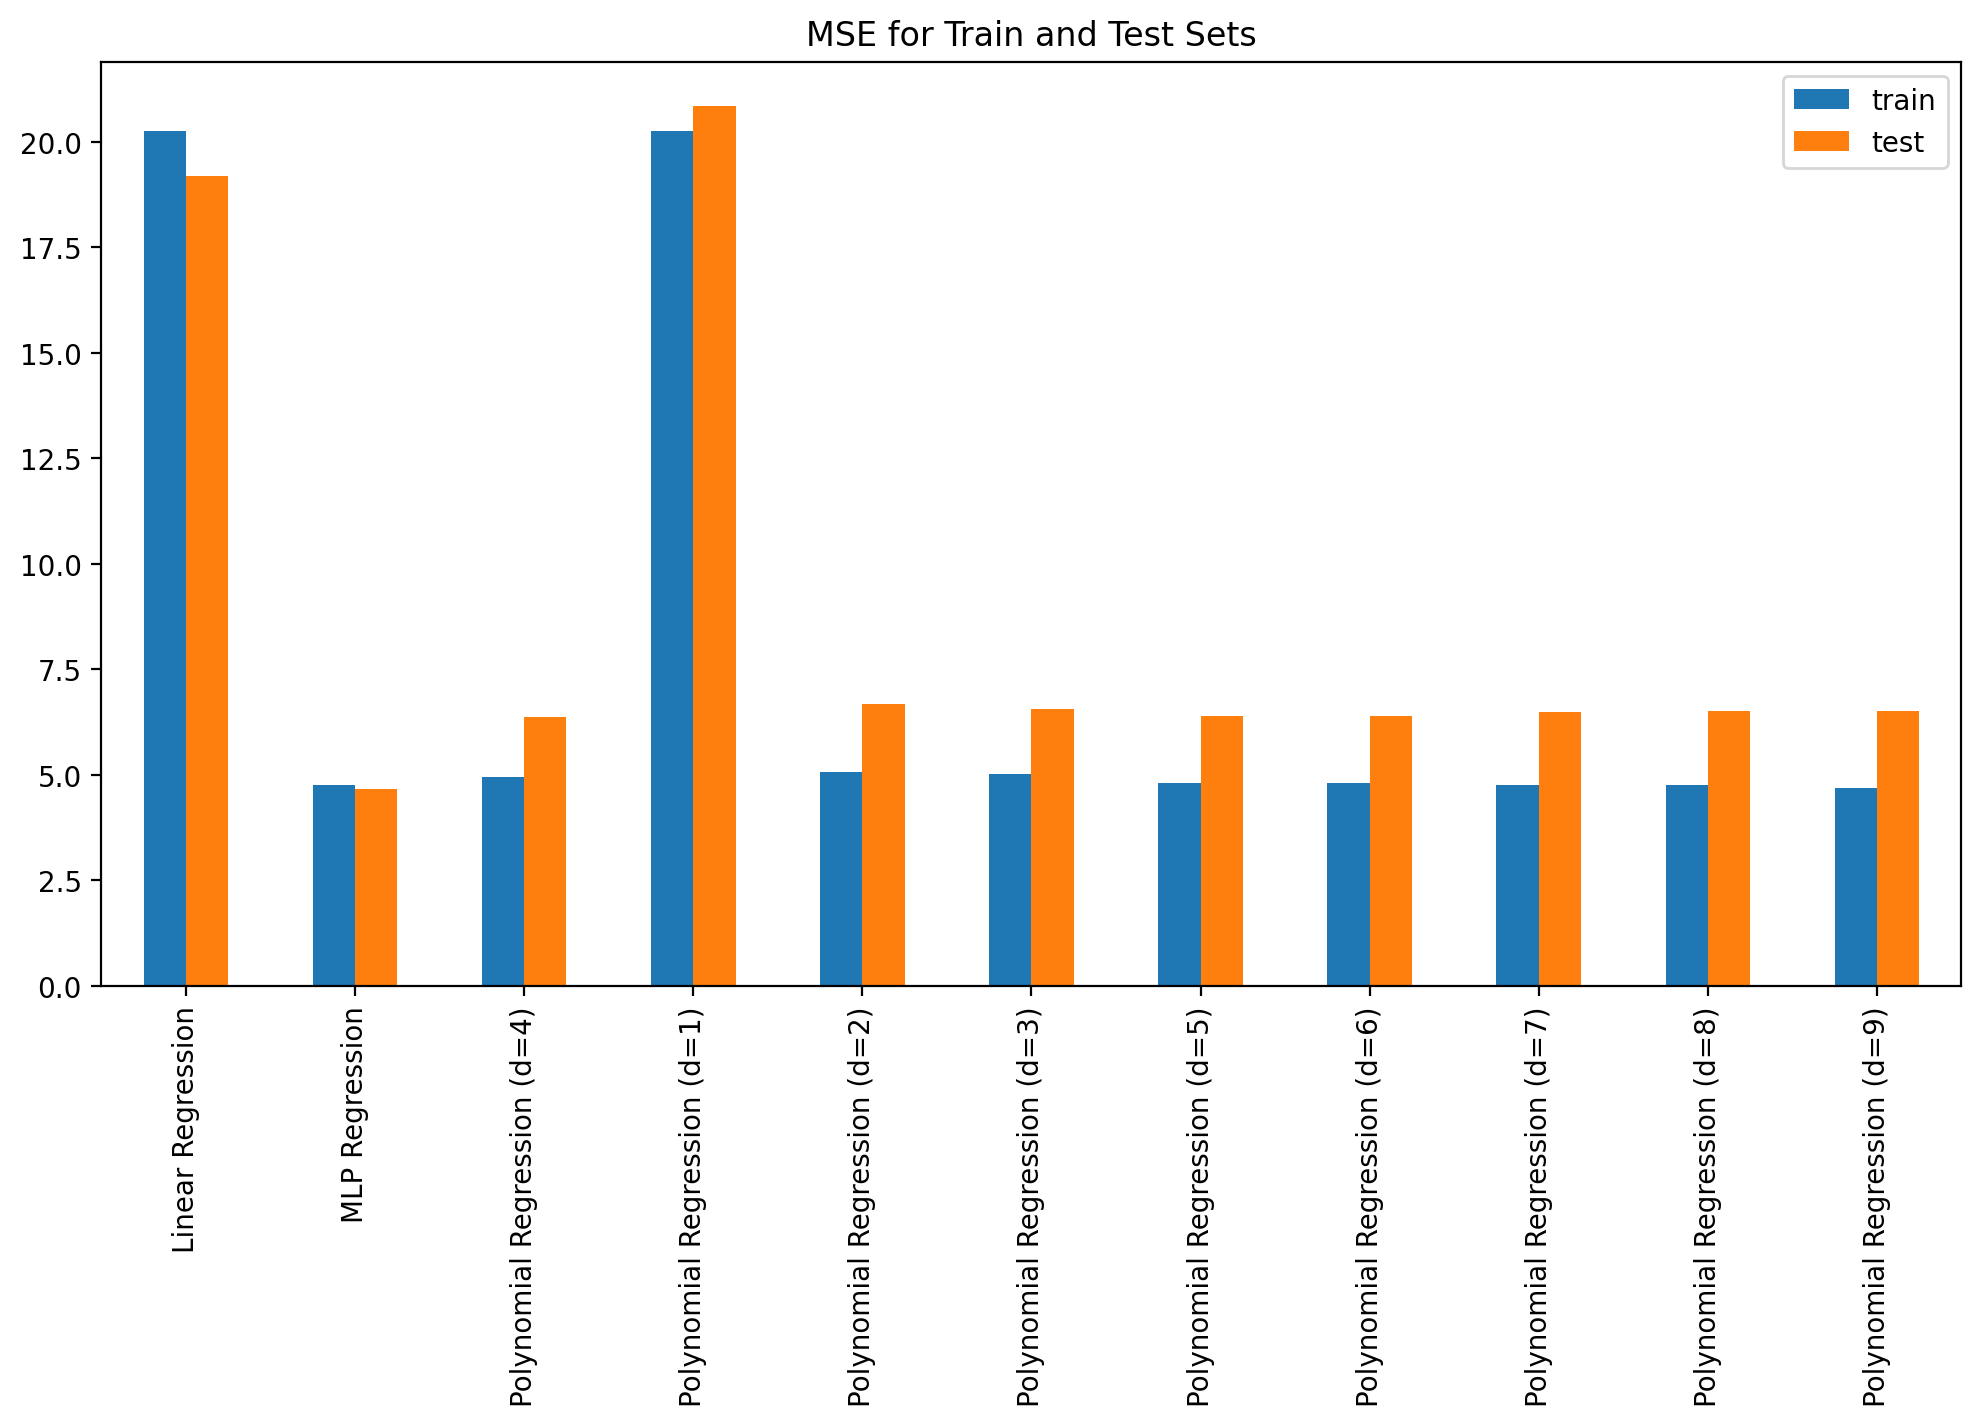

In [24]:
errors_df.plot(kind='bar', figsize=(12, 6), title='MSE for Train and Test Sets')

In [25]:
# bias variance tradeoff

errors_poly = {}

for degree in range(1, 20):
    Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_poly_features(X_lin_1d, degree)

    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, degree, plot=False)

    # geting errors for polynomial regression only for plotting
    errors_poly[degree] = errors[degree]

Best degree: 4, Min error: 6.567621493533497


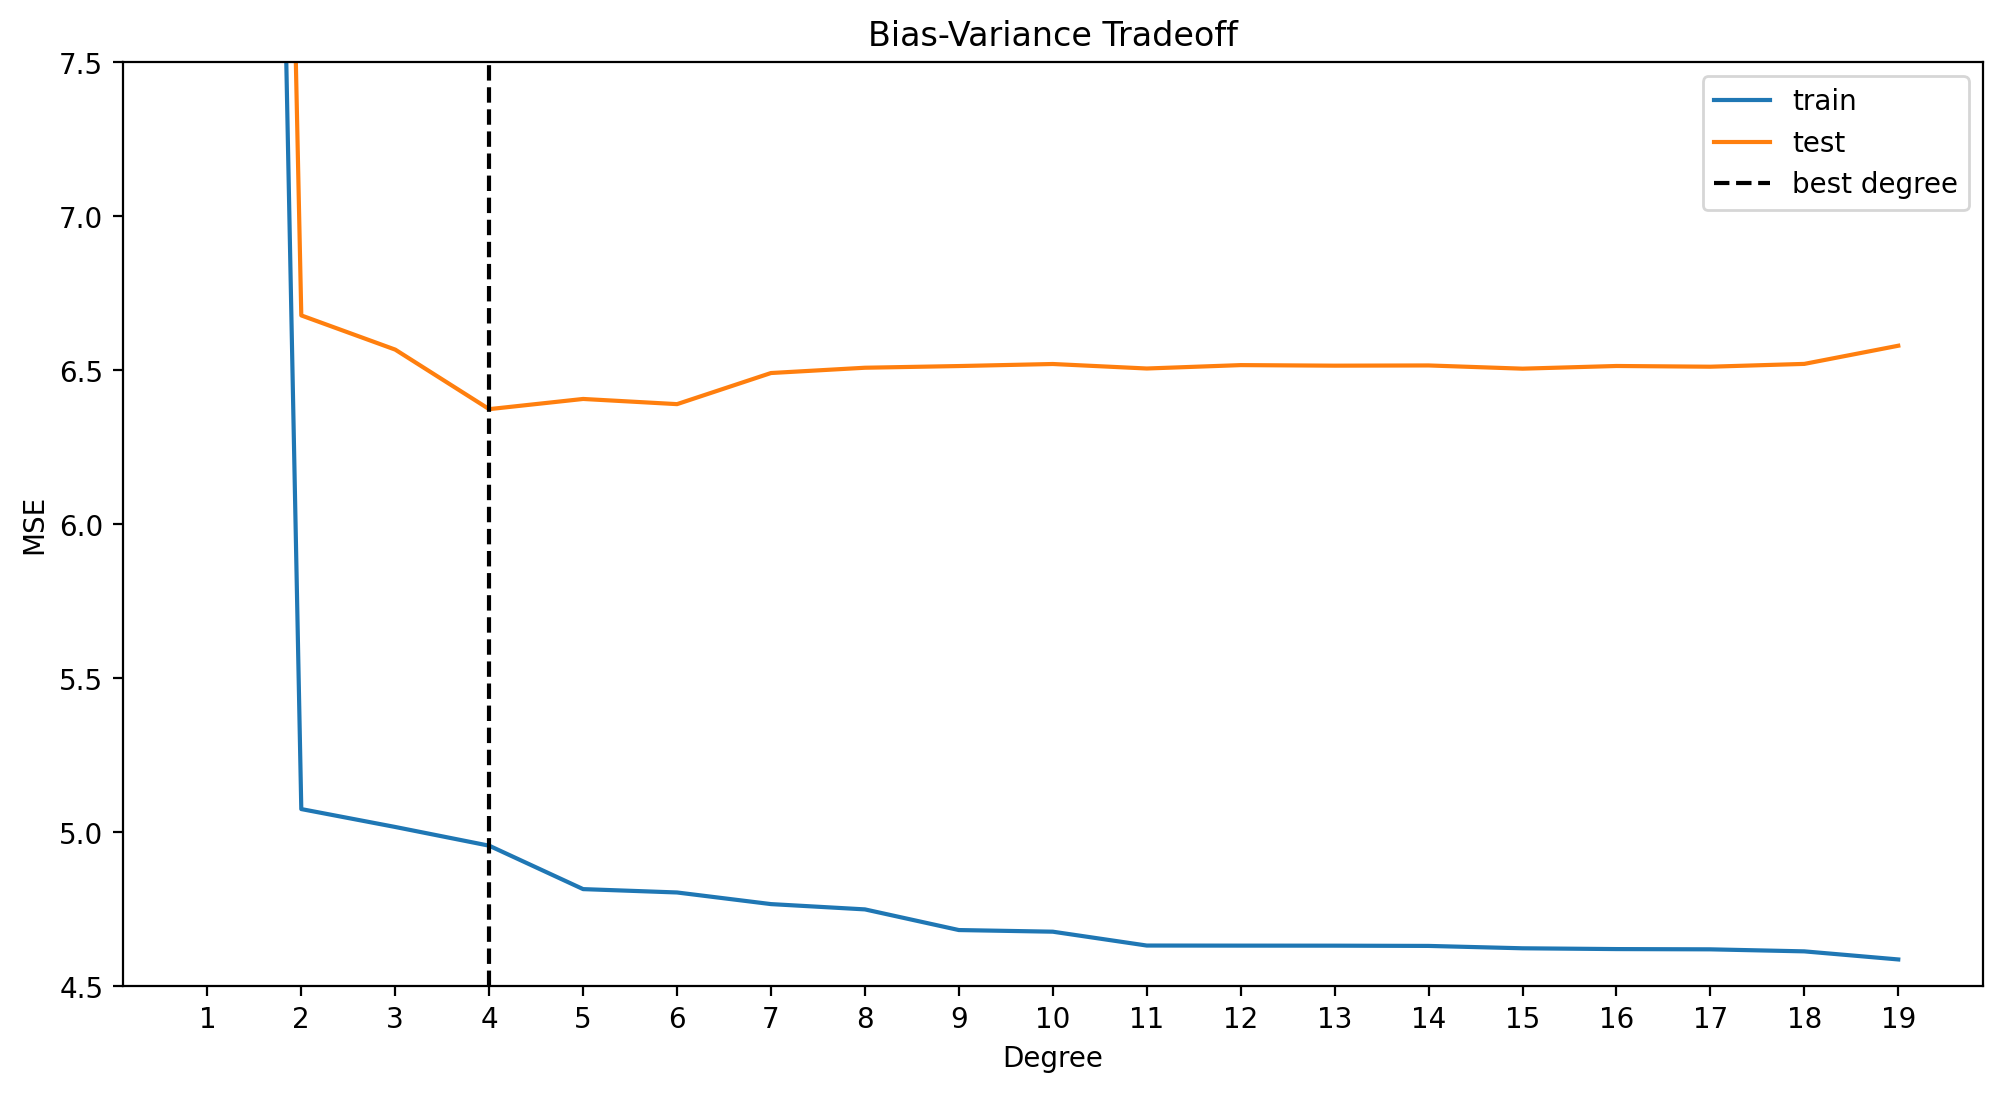

In [26]:
errors_poly_df = pd.DataFrame(errors_poly).T
best_degree = np.argmin(errors_poly_df.test) + 1
min_error = errors_poly_df.test[best_degree - 1]    # index of df = degree - 1
print(f"Best degree: {best_degree}, Min error: {min_error}")

# set figure size
plt.figure(figsize=(12, 6))
plt.plot(errors_poly_df.index, errors_poly_df.train, label='train')
plt.plot(errors_poly_df.index, errors_poly_df.test, label='test')
plt.axvline(best_degree, color='black', linestyle='--', label='best degree')
plt.xticks(np.arange(min(errors_poly_df.index), max(errors_poly_df.index)+1, 1.0))
plt.ylim(4.5, 7.5)      # set y limit - to show the difference between train and test clearly
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()

In [27]:
# plot for successively adding polynomial features to show how close we get to train

degree = 8
X_poly = create_poly_features(X_norm, degree)
model3 = LinearRegression()
Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)
X_lin_poly = create_poly_features(X_lin_1d, degree)
plot_fit_predict(model3, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Succesively adding polynomial features", plot=False)

{'train': 4.750171469190139, 'test': 6.508794709125083}

In [28]:
model3.coef_, model3.intercept_

(array([[ 0.90185654,  0.1300646 ,  0.34425478, -0.16754834, -0.42642036,
          0.35487396,  0.17341507, -0.19121703]]),
 array([-0.01122412]))

In [29]:
# create a new array having model3.intercept_ as first element and model3.coef_ as rest of the elements
params = np.concatenate((model3.intercept_, model3.coef_.flatten())).reshape(-1, 1)
params

array([[-0.01122412],
       [ 0.90185654],
       [ 0.1300646 ],
       [ 0.34425478],
       [-0.16754834],
       [-0.42642036],
       [ 0.35487396],
       [ 0.17341507],
       [-0.19121703]])

In [30]:
# pad ones at the beginning of Xf_norm_train and Xf_norm_test to make them compatible with params
Xf_norm_train_padded = np.concatenate((np.ones((len(Xf_norm_train), 1)), Xf_norm_train), axis=1)
Xf_norm_test_padded = np.concatenate((np.ones((len(Xf_norm_test), 1)), Xf_norm_test), axis=1)
X_lin_poly_padded = np.concatenate((np.ones((len(X_lin_poly), 1)), X_lin_poly), axis=1)

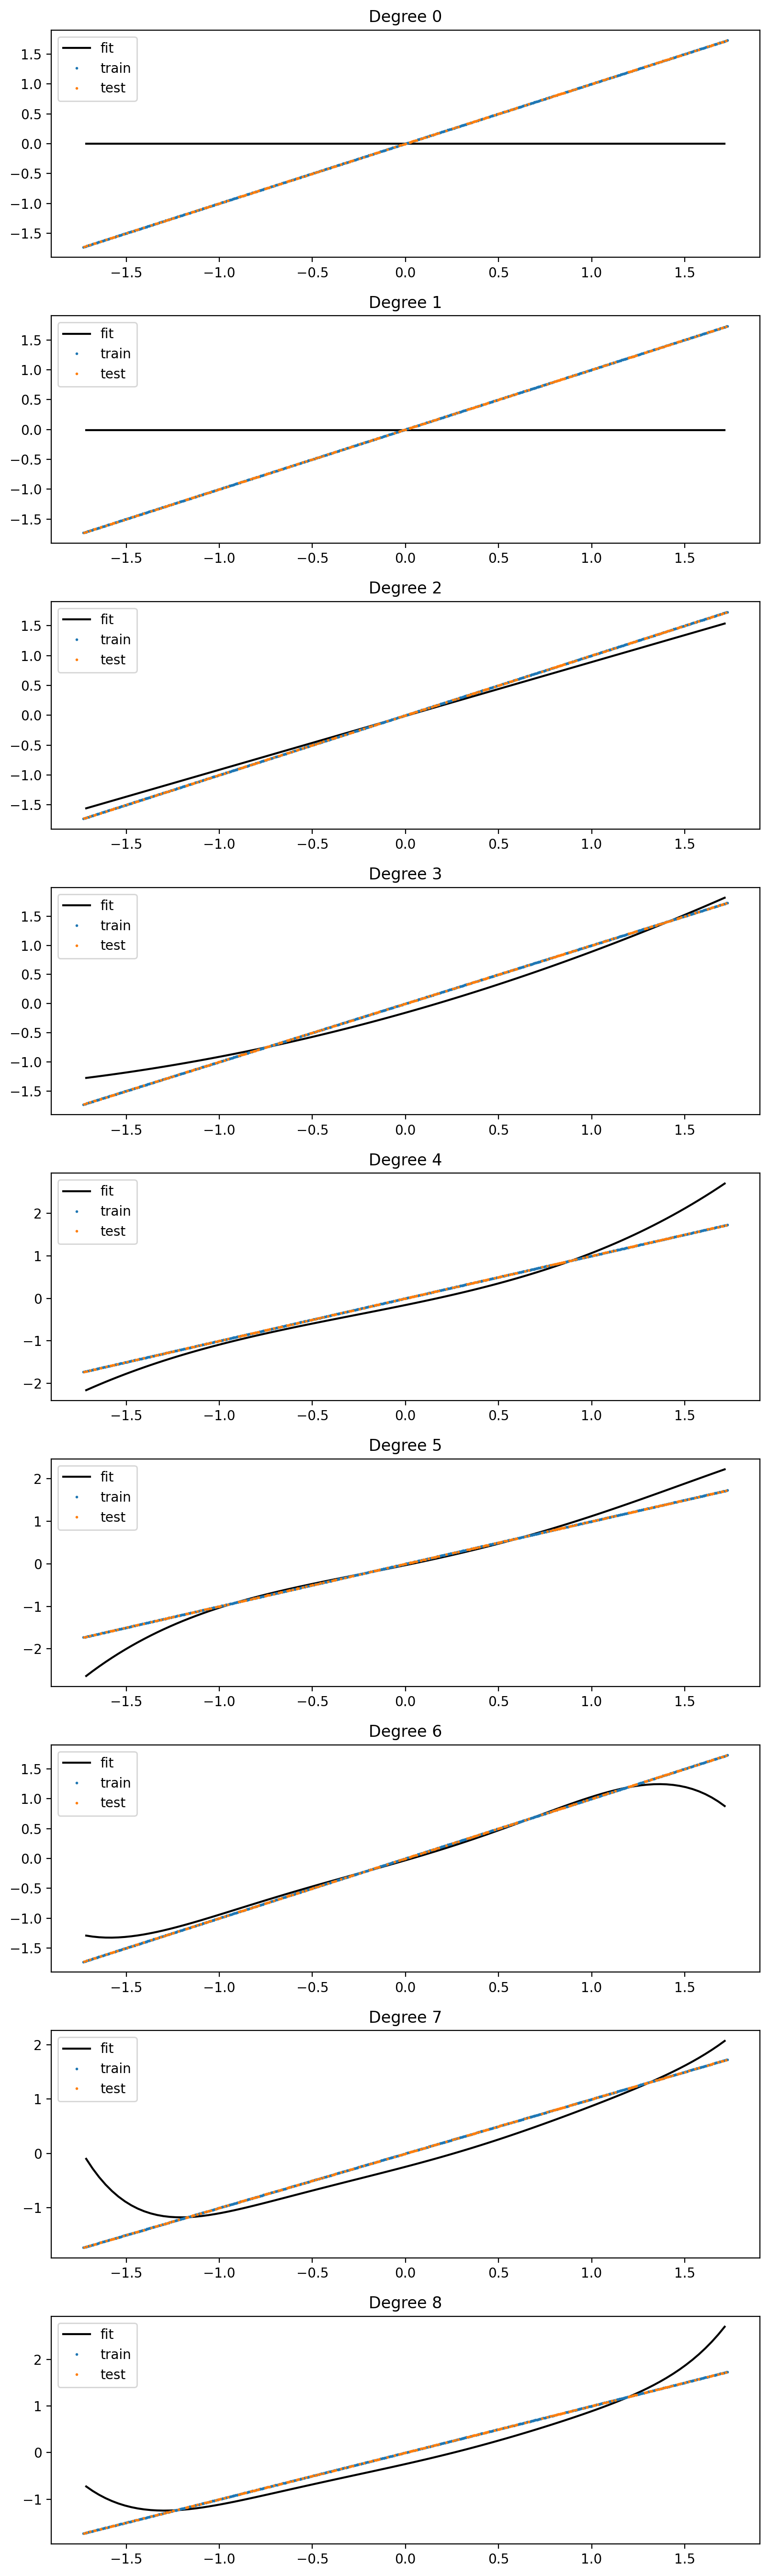

In [31]:
# create a plot consisting of 4 subplots to show how the model fits the data as we add more polynomial features
fig, axes = plt.subplots(degree+1, 1, figsize=(8, (degree+1)*3))
for i in range(0, degree+1):
    axes[i].plot(X_lin_poly_padded[:, 1], np.matmul(X_lin_poly_padded[:, :i], params[:i, :]), label='fit', color='black')
    axes[i].plot(X_norm_train, X_norm_train, 'o', label='train', markersize=1)
    axes[i].plot(X_norm_test, X_norm_test, 'o', label='test', ms=1)

    axes[i].set_title(f"Degree {i}")
    axes[i].legend()

plt.tight_layout()
plt.show()

### Ridge Regression with polynomial basis

In [32]:
# initiate ridge regression model
model_ridge = Ridge(alpha=0.1)

errors_ridge = {}

for degree in range(1, 20):
    Xf_norm_train = create_poly_features(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_poly_features(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_poly_features(X_lin_1d, degree)

    plot_fit_predict(model_ridge, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f'ridge_{degree}', plot=False)

    # geting errors for polynomial regression only for plotting
    errors_ridge[degree] = errors[f'ridge_{degree}']

Best degree: 4, Min error: 6.556584029281782


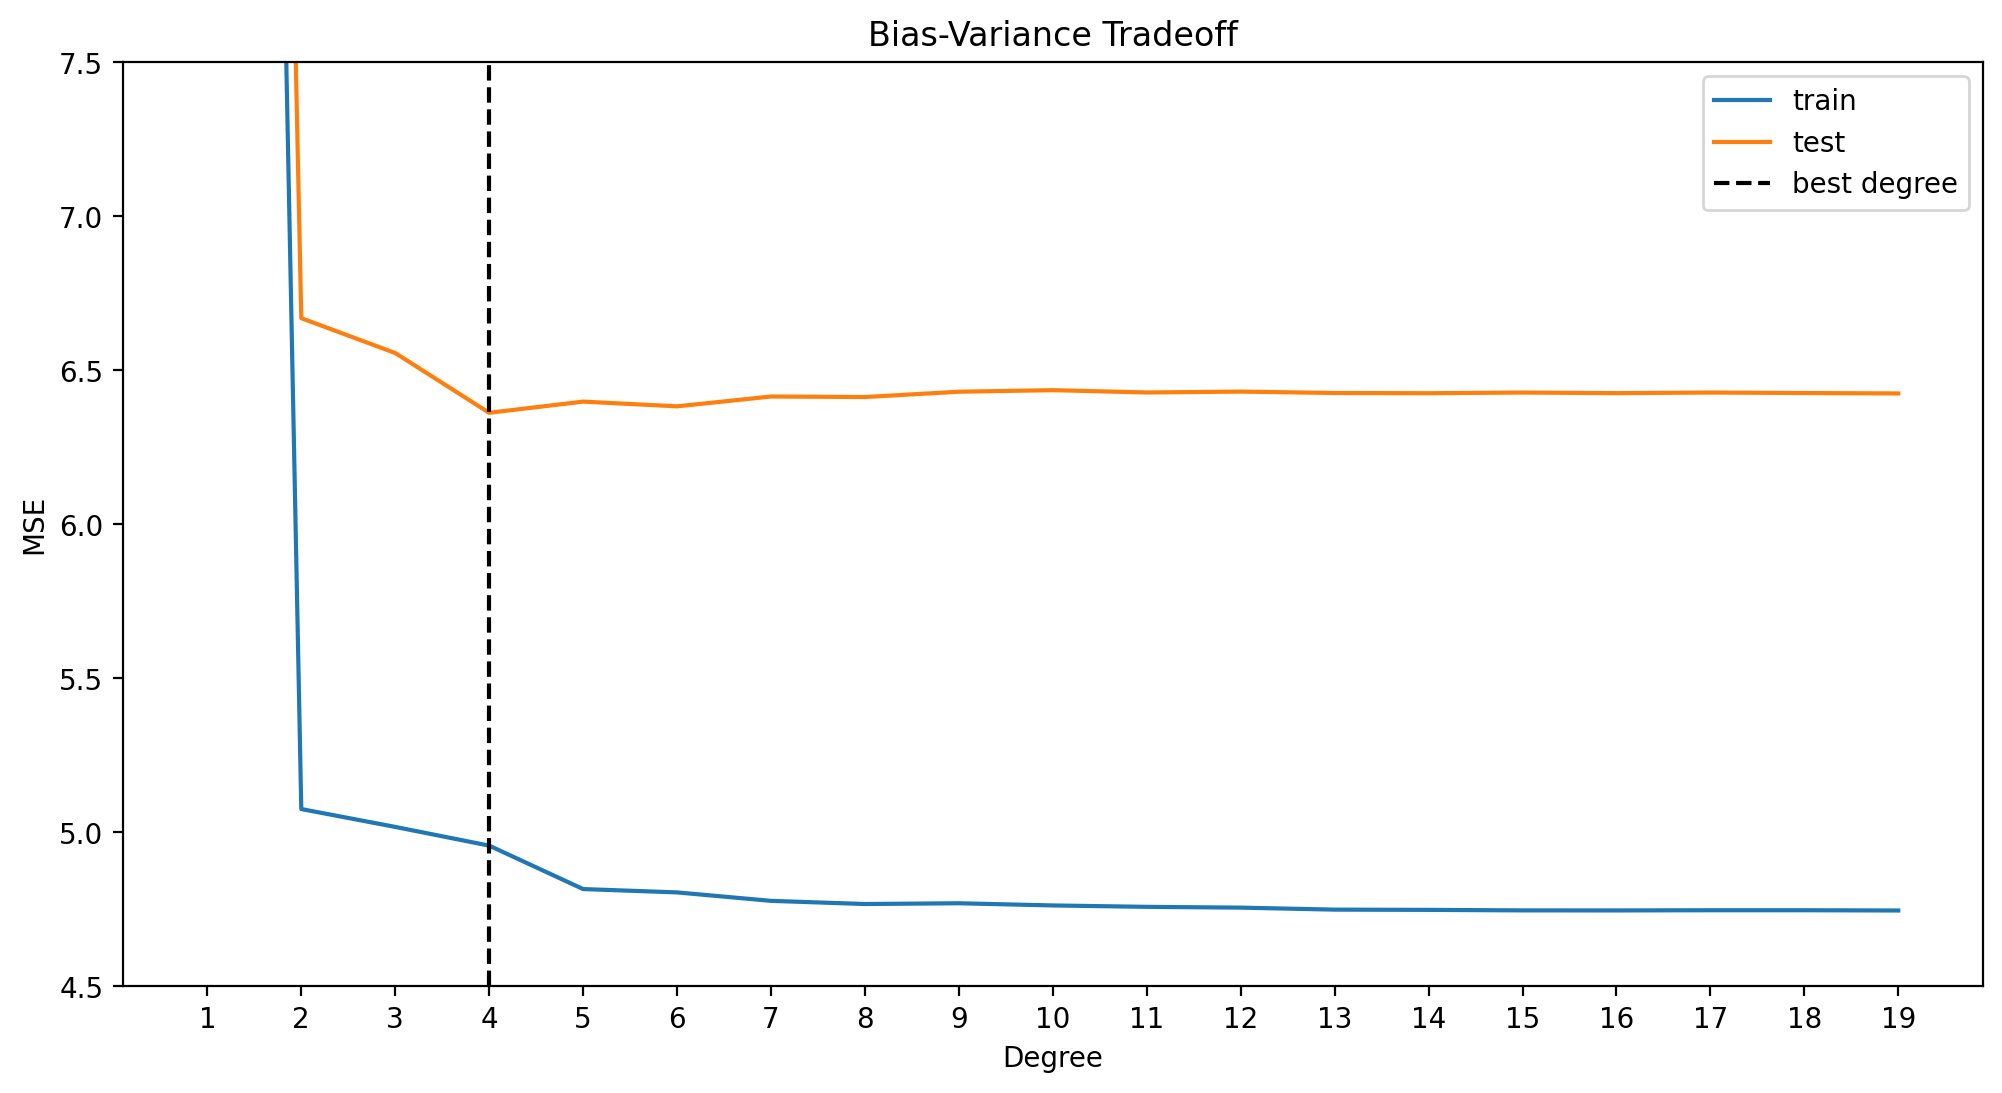

In [33]:
errors_ridge_df = pd.DataFrame(errors_ridge).T
best_degree_ridge = np.argmin(errors_ridge_df.test) + 1
min_error = errors_ridge_df.test[best_degree_ridge - 1]    # index of df = degree - 1
print(f"Best degree: {best_degree_ridge}, Min error: {min_error}")

# set figure size
plt.figure(figsize=(12, 6))
plt.plot(errors_ridge_df.index, errors_ridge_df.train, label='train')
plt.plot(errors_ridge_df.index, errors_ridge_df.test, label='test')
plt.axvline(best_degree_ridge, color='black', linestyle='--', label='best degree')
plt.xticks(np.arange(min(errors_ridge_df.index), max(errors_ridge_df.index)+1, 1.0))
plt.ylim(4.5, 7.5)      # set y limit - to show the difference between train and test clearly
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()

{'train': 4.7465713466226696, 'test': 6.425333988832884}

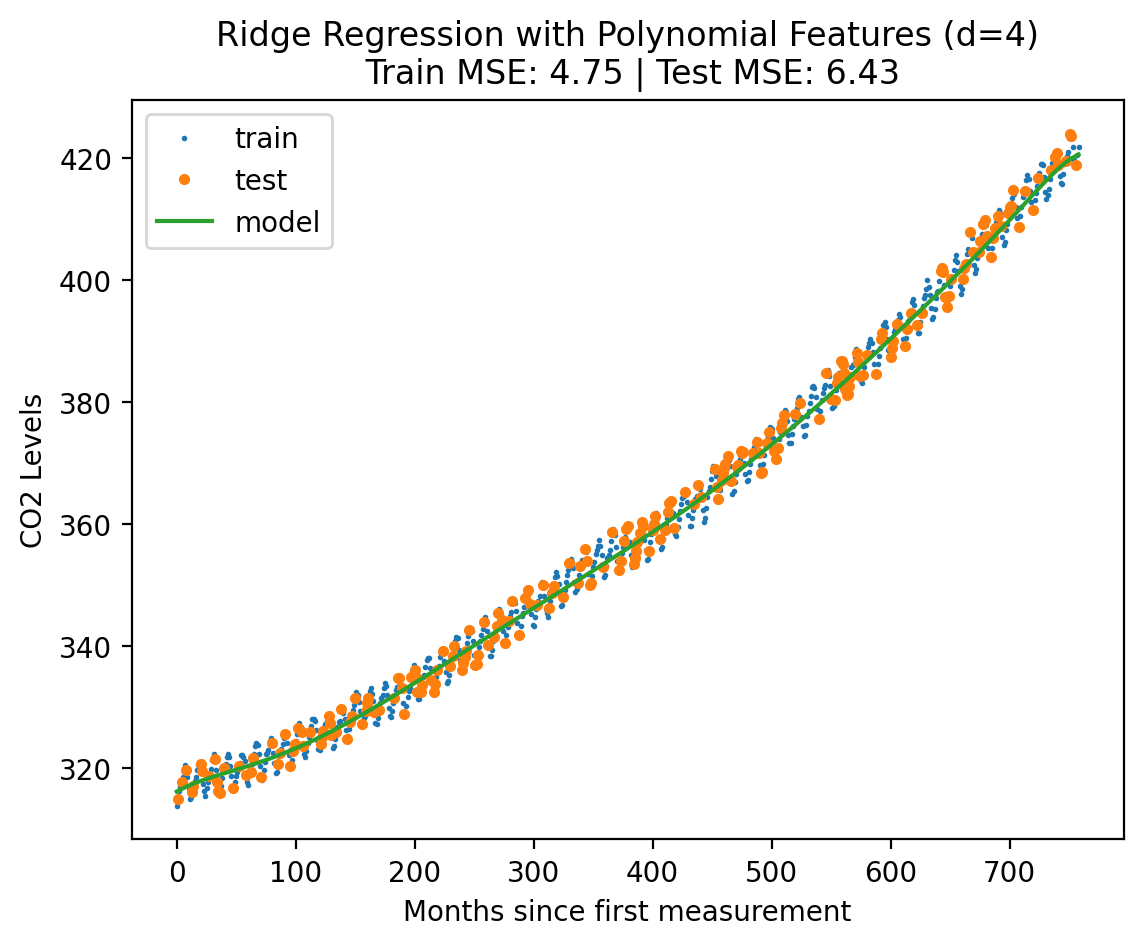

In [34]:
plot_fit_predict(model_ridge, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Ridge Regression with Polynomial Features (d={best_degree_ridge})", plot=True)

### Gausian Basis Function

In [35]:
def create_guassian_basis(X , d , std = 1):
    """
    X is (N, 1) array
    d is number of basis functions
    """
    means = np.linspace(X.min(), X.max(), d)
    X = np.repeat(X, d, axis=1)
    means = np.repeat(means.reshape(-1, 1), len(X), axis=1).T

    return np.exp(-(X - means) ** 2 / (2 * std ** 2))

{'train': 13.136796592517122, 'test': 13.472607711972323}

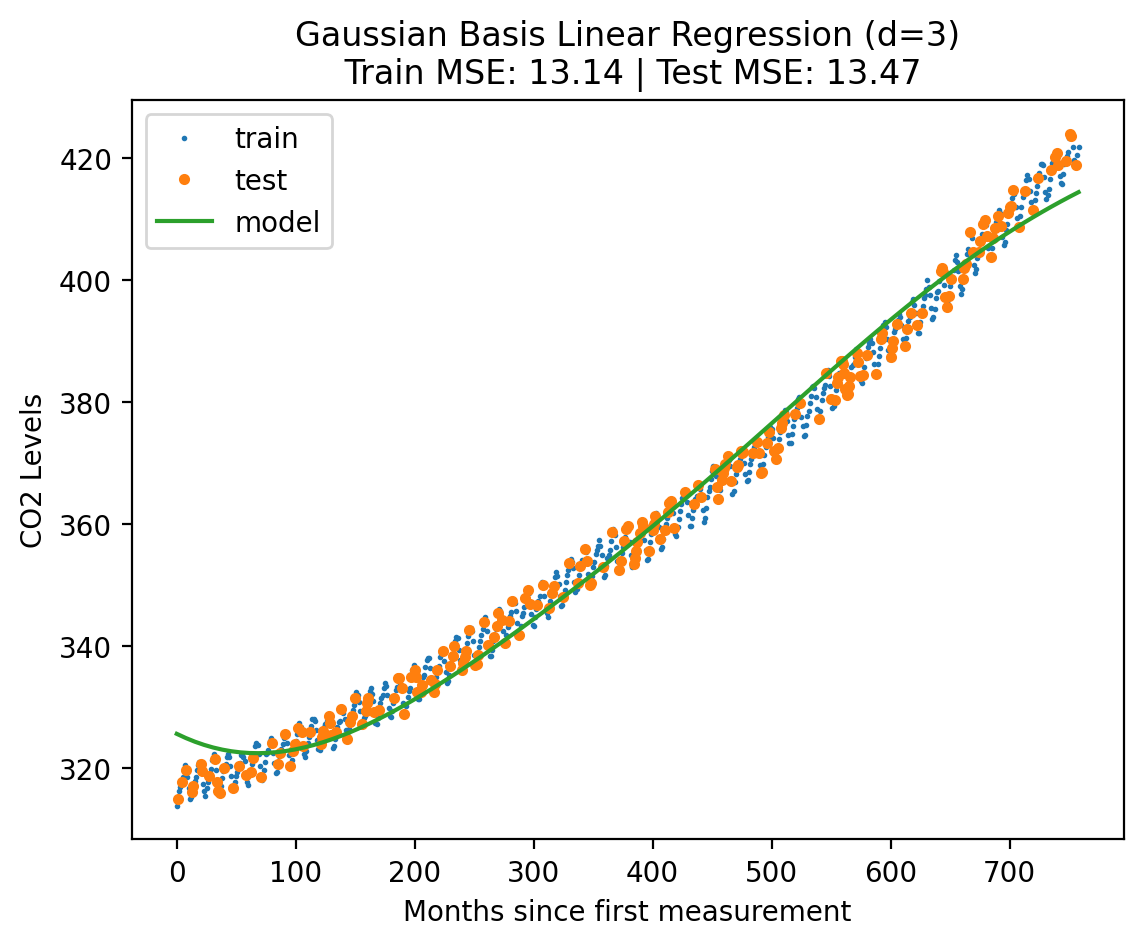

In [36]:
model_gauss = LinearRegression()
degree = 3
Xf_norm_train = create_guassian_basis(X_norm_train.reshape(-1, 1), degree)
Xf_norm_test = create_guassian_basis(X_norm_test.reshape(-1, 1), degree)

X_lin_poly = create_guassian_basis(X_lin_1d, degree)


plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Gaussian Basis Linear Regression (d={degree})")

In [37]:
errors.clear()

In [38]:
for degree in range(1, 10):
    Xf_norm_train = create_guassian_basis(X_norm_train.reshape(-1, 1), degree)
    Xf_norm_test = create_guassian_basis(X_norm_test.reshape(-1, 1), degree)

    X_lin_poly = create_guassian_basis(X_lin_1d, degree)


    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Gaussian Basis Linear Regression (d={degree})", plot=False)

In [39]:
errors_df = pd.DataFrame(errors).T

<Axes: title={'center': 'MSE for Train and Test Sets'}>

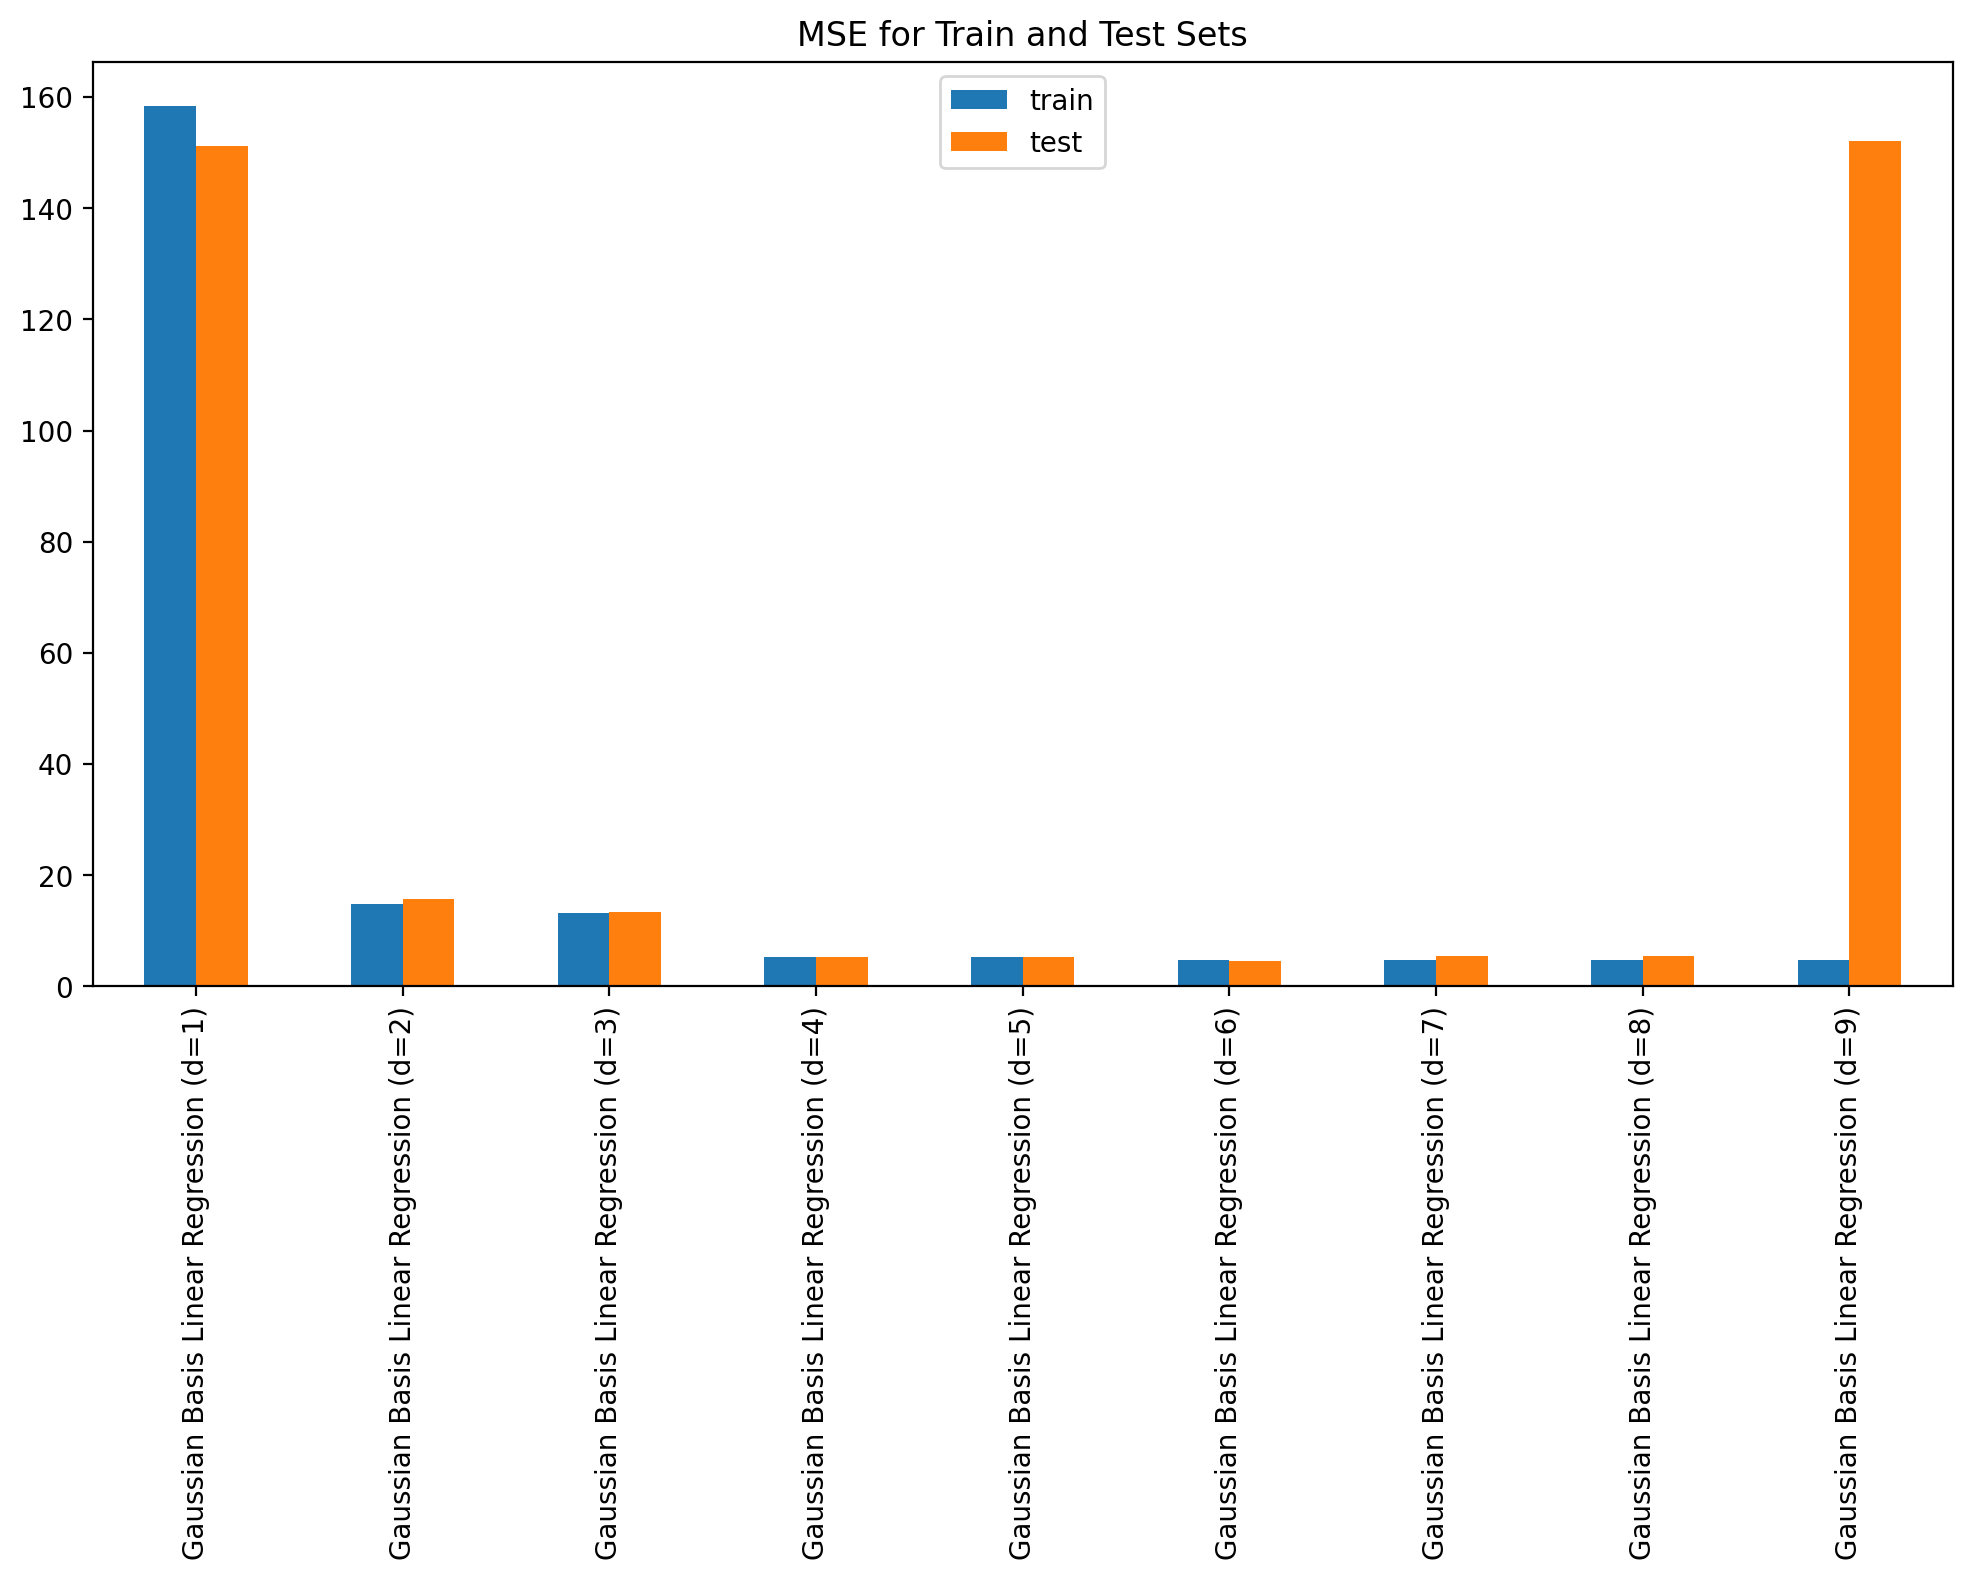

In [40]:
errors_df.plot(kind='bar', figsize=(12, 6), title='MSE for Train and Test Sets')

In [41]:
errors.clear()

In [42]:
# Bias Variance Tradeoff wrt Sigma

for std in [0.1, 0.5, 1, 2, 5, 10]:
    Xf_norm_train = create_guassian_basis(X_norm_train.reshape(-1, 1), 3, std)
    Xf_norm_test = create_guassian_basis(X_norm_test.reshape(-1, 1), 3, std)

    X_lin_poly = create_guassian_basis(X_lin_1d, 3, std)

    plot_fit_predict(model2, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_poly, f"Gaussian Basis Linear Regression (d=3, std={std})", plot=False)

Text(0.5, 1.0, 'Bias Variance Tradeoff wrt Sigma')

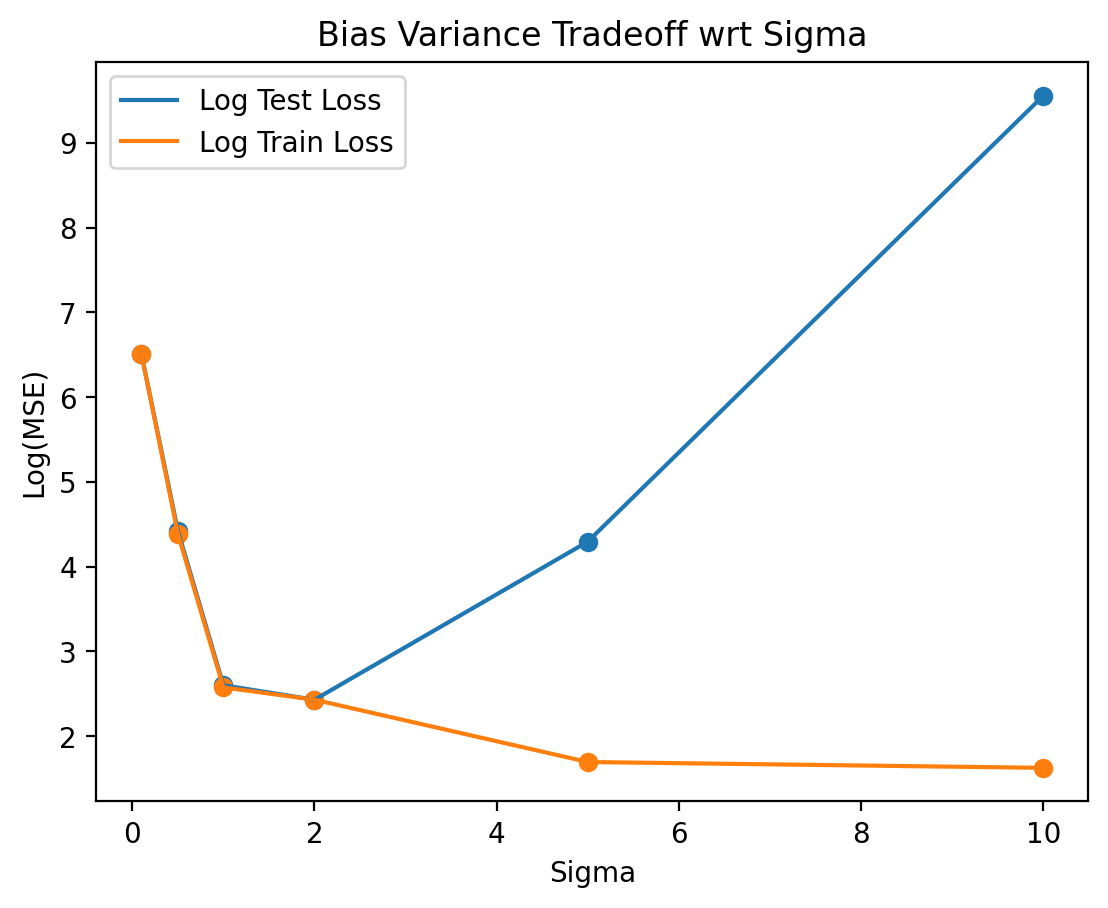

In [43]:
# Plot the train and test errors for different values of sigma

errors_df = pd.DataFrame(errors).T

test_errors = errors_df.test.values
train_errors = errors_df.train.values

log_test_errors = np.log(test_errors)
log_train_errors = np.log(train_errors)

stds = [0.1, 0.5, 1, 2, 5, 10]

plt.plot(stds , log_test_errors, label='Log Test Loss')
plt.plot(stds , log_train_errors, label='Log Train Loss')
plt.scatter(stds, log_test_errors)
plt.scatter(stds, log_train_errors)
plt.legend()
plt.xlabel('Sigma')
plt.ylabel('Log(MSE)')
plt.title('Bias Variance Tradeoff wrt Sigma')

### Gaussian Process

In [44]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

In [45]:
# Using GP for the interpolation problem

from sklearn.gaussian_process import GaussianProcessRegressor

def plot_fit_gp(X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin, title, plot=True):

    gaussian_process = GaussianProcessRegressor(
        kernel=co2_kernel,n_restarts_optimizer=9
    )

    gaussian_process.fit(X_norm_train, y_norm_train)

    y_hat_train, std_prediction_train = gaussian_process.predict(X_norm_train, return_std=True)
    y_hat_test , std_prediction_test = gaussian_process.predict(X_norm_test, return_std=True)

    y_hat_train = y_hat_train.reshape(-1, 1)
    y_hat_test = y_hat_test.reshape(-1, 1)

    # Transform back to original scale
    y_hat_train = s2.inverse_transform(y_hat_train)
    y_hat_test = s2.inverse_transform(y_hat_test)

    y_hat_lin , std_prediction_lin = gaussian_process.predict(X_lin , return_std=True)
    y_hat_lin = y_hat_lin.reshape(-1, 1)
    y_hat_lin = s2.inverse_transform(y_hat_lin)

    errors[title] = {"train": mean_squared_error(y_train, y_hat_train),
                     "test": mean_squared_error(y_test, y_hat_test)}

    if plot:
        plt.plot(X_train, y_train, 'o', label='train',markersize=1)
        plt.plot(X_test, y_test, 'o', label='test', ms=3)
        plt.plot(s1.inverse_transform(X_lin_1d), y_hat_lin, label='model')
        plt.fill_between(s1.inverse_transform(X_lin_1d).reshape(-1), 
                         (y_hat_lin - 1.96*std_prediction_lin.reshape(-1,1)).reshape(-1), 
                         (y_hat_lin + 1.96*std_prediction_lin.reshape(-1,1)).reshape(-1), alpha=0.5 , label='95% Confidence interval')
        plt.xlabel('Months since first measurement')
        plt.ylabel('CO2 Levels')
        plt.legend()

        plt.title('{}\n Train MSE: {:.2f} | Test MSE: {:.2f}'.format(title, errors[title]["train"], errors[title]["test"]))

    return errors[title]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and call

{'train': 0.015816774386383247, 'test': 0.3385105836213672}

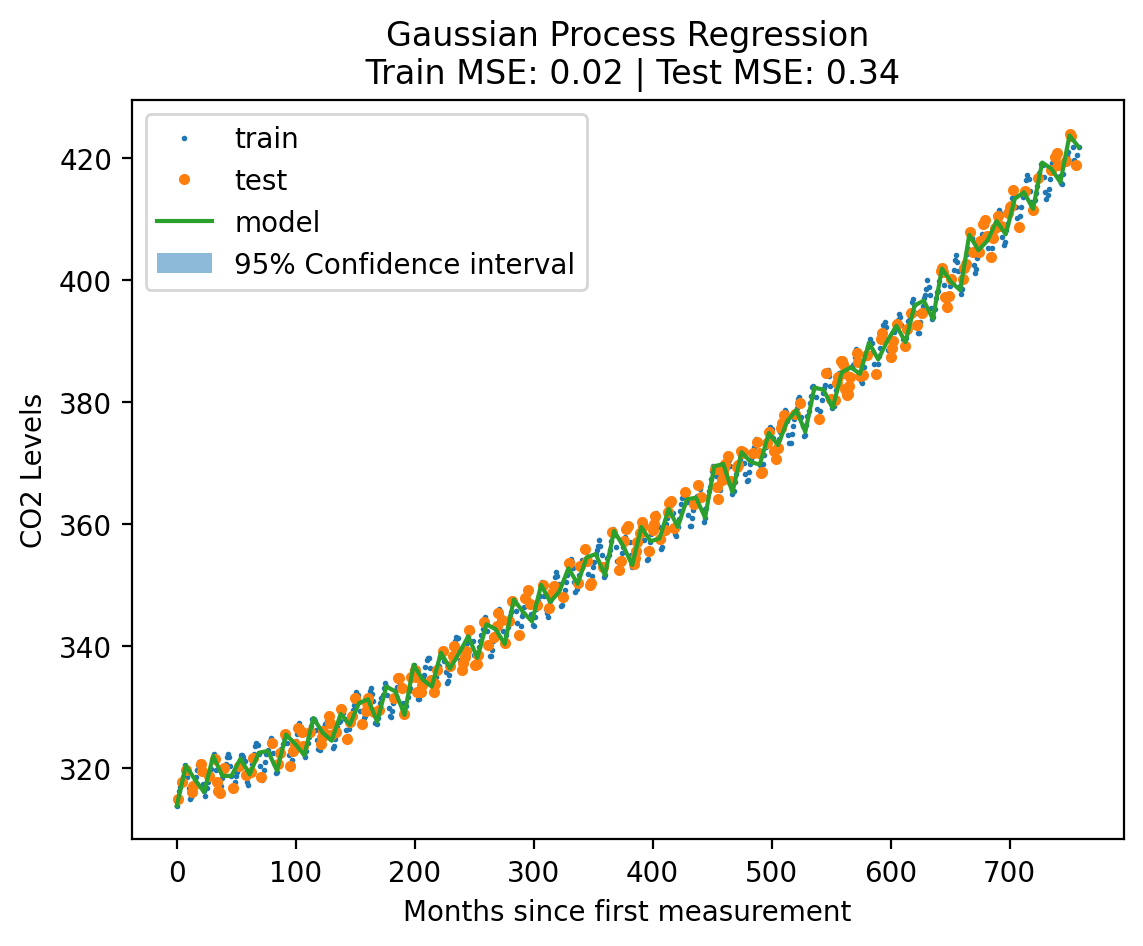

In [46]:
plot_fit_gp(X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "Gaussian Process Regression")

### Fourier Features
Reference: https://bmild.github.io/fourfeat/

##### Fourier Feature Mapping

For every input x, we map it to a higher dimensional space using the following function:

$$\gamma(x) = [\cos(2\pi Bx), \sin(2\pi Bx)]^{T} $$

where $B$ is a random Gaussian matrix, where each entry is drawn independently from a normal distribution N(0, $σ^{2}$)

[ 0.99342831 -0.2765286   1.29537708]


Text(0.5, 1.0, 'Fourier Featurization of X manually')

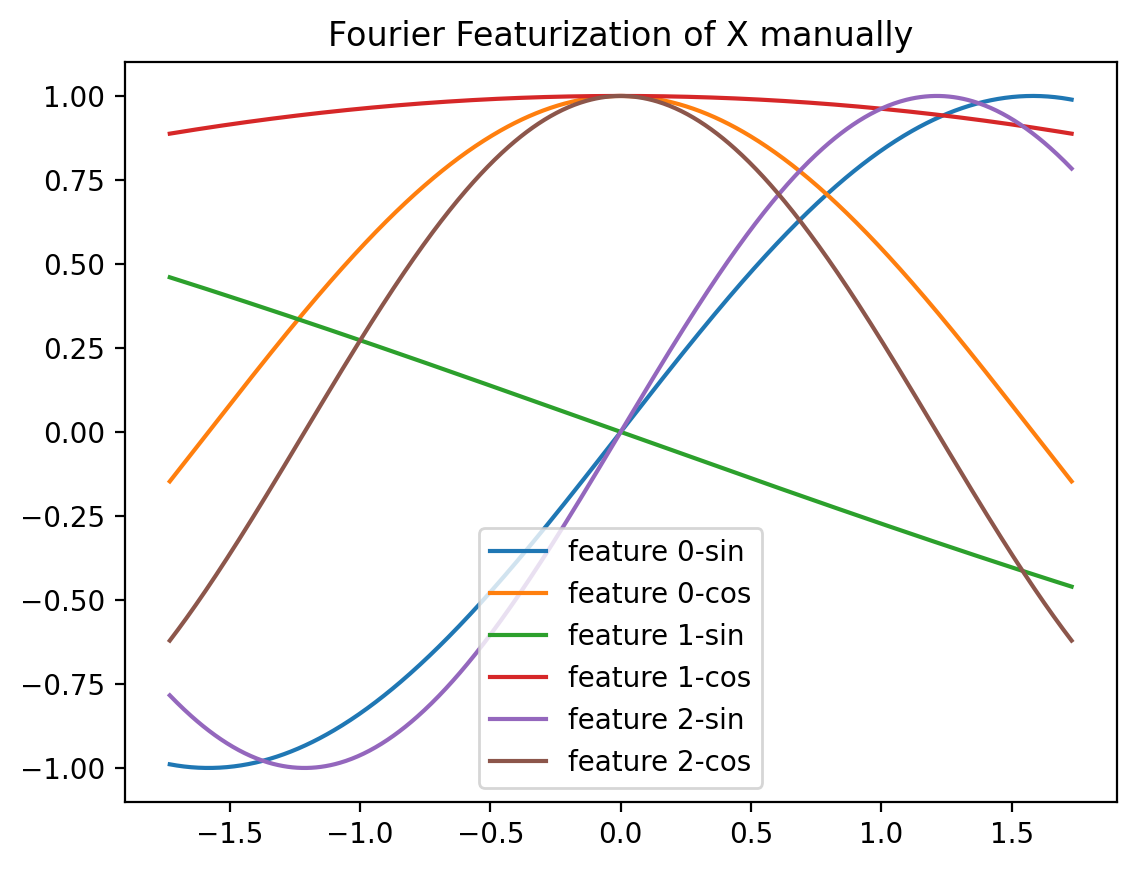

In [47]:
np.random.seed(42)
gamma = 2
NUM_features = 3
fs = gamma*np.random.randn(NUM_features)
print(fs)

for i in range(NUM_features):
    plt.plot(X_norm, np.sin(fs[i]*X_norm), label=f'feature {i}-sin')
    plt.plot(X_norm, np.cos(fs[i]*X_norm), label=f'feature {i}-cos')
plt.legend()
plt.title('Fourier Featurization of X manually')

In [48]:
# Explicit implementation of RFF

def create_random_features(X, gamma, NUM_features):
    """
    X is (N, 1) array
    gamma is a scalar
    NUM_features is a scalar
    """
    
    X_rff = np.zeros((len(X), 2*NUM_features + 1))
    X_rff[:, 0] = X[:, 0]
    for i in range(NUM_features):
        b = np.random.randn()
        X_rff[:, i+1] = np.sin(2*np.pi*gamma*b*X[:, 0])
        X_rff[:, i + NUM_features+1] = np.cos(2*np.pi*gamma*b*X[:, 0])
    
    # Normalize each column
    X_rff = StandardScaler().fit_transform(X_rff)
    return X_rff


##### Sklearn Implementation

In [49]:
# Sklearn's implementation of RFF

from sklearn.kernel_approximation import RBFSampler
RBFSampler?

Init signature: RBFSampler(*, gamma=1.0, n_components=100, random_state=None)
Docstring:     
Approximate a RBF kernel feature map using random Fourier features.

It implements a variant of Random Kitchen Sinks.[1]

Read more in the :ref:`User Guide <rbf_kernel_approx>`.

Parameters
----------
gamma : 'scale' or float, default=1.0
    Parameter of RBF kernel: exp(-gamma * x^2).
    If ``gamma='scale'`` is passed then it uses
    1 / (n_features * X.var()) as value of gamma.

    .. versionadded:: 1.2
       The option `"scale"` was added in 1.2.

n_components : int, default=100
    Number of Monte Carlo samples per original feature.
    Equals the dimensionality of the computed feature space.

random_state : int, RandomState instance or None, default=None
    Pseudo-random number generator to control the generation of the random
    weights and random offset when fitting the training data.
    Pass an int for reproducible output across multiple function calls.
    See :term:`Glossary <

Text(0.5, 1.0, 'Fourier Featurization using RBFSampler (sklearn)')

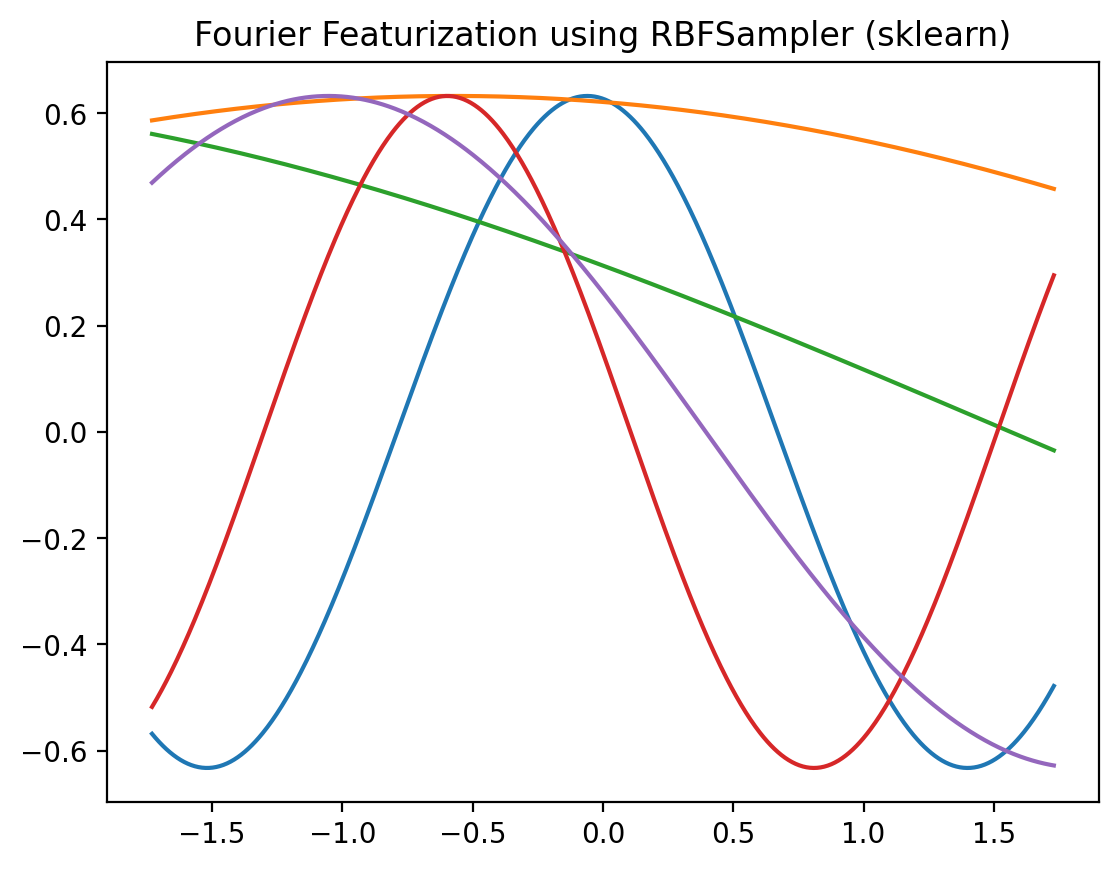

In [50]:
r= RBFSampler(n_components=5)
plt.plot(X_norm, r.fit_transform(X_norm.reshape(-1,1)))
plt.title('Fourier Featurization using RBFSampler (sklearn)')

Text(0.5, 1.0, 'Fourier Featurization using RBFSampler (sklearn)')

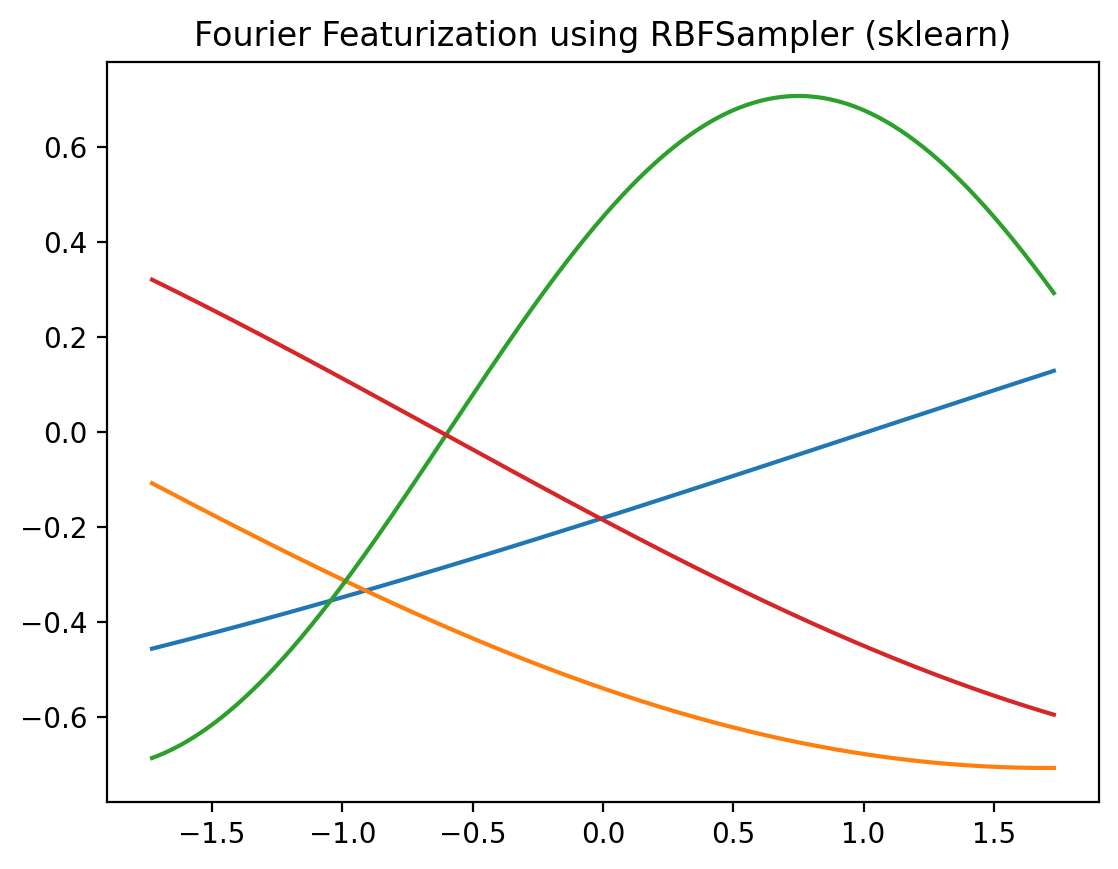

In [51]:
r = RBFSampler(n_components=4, gamma=0.1)
plt.plot(X_norm, r.fit_transform(X_norm.reshape(-1,1)))
plt.title('Fourier Featurization using RBFSampler (sklearn)')

Text(0.5, 1.0, 'Fourier Featurization using RBFSampler (sklearn)')

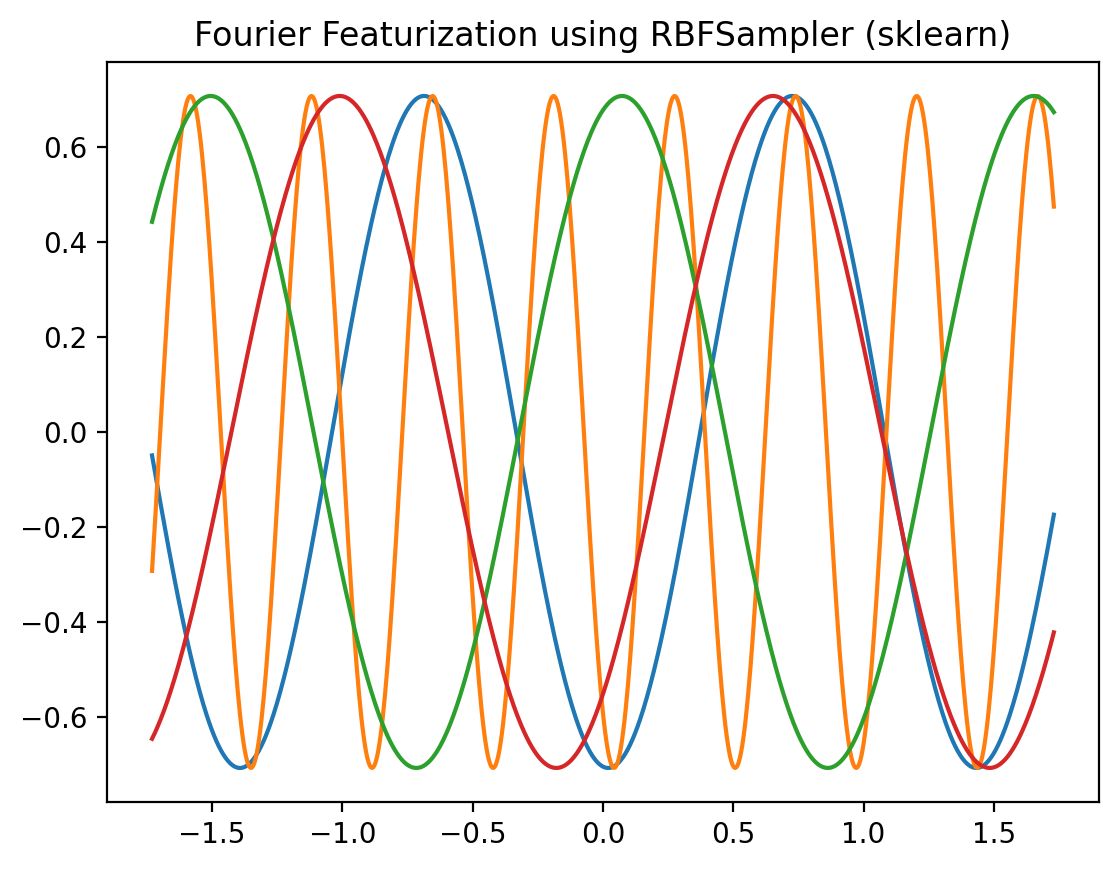

In [52]:
r = RBFSampler(n_components=4, gamma=20)
plt.plot(X_norm, r.fit_transform(X_norm.reshape(-1,1)))
plt.title('Fourier Featurization using RBFSampler (sklearn)')

In [53]:
# Implicit implementation of RFF using sklearn

def create_rff(X, gamma, NUM_features):
    # Random Fourier Features
    # https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
    rbf_feature = RBFSampler(gamma=gamma, n_components=NUM_features, random_state=1)
    X_features = rbf_feature.fit_transform(X)
    return X_features

{'train': 5.035023975072016, 'test': 4.782073267288176}

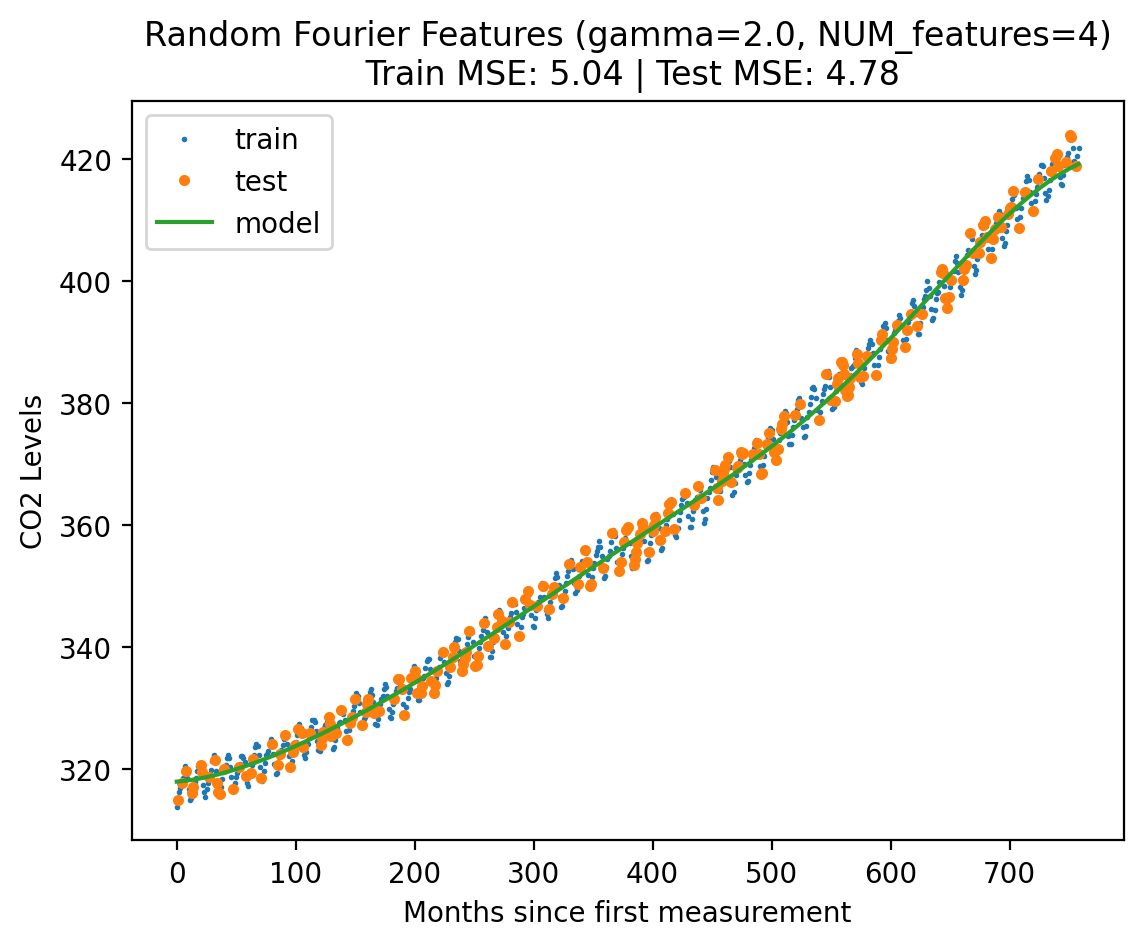

In [54]:
model3 = LinearRegression()
gamma = 2.0
NUM_features = 4

Xf_norm_train = create_rff(X_norm_train.reshape(-1, 1), gamma, NUM_features)
Xf_norm_test = create_rff(X_norm_test.reshape(-1, 1), gamma, NUM_features)

X_lin_rff = create_rff(X_lin_1d, gamma, NUM_features)

plot_fit_predict(model3, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_rff, f"Random Fourier Features (gamma={gamma}, NUM_features={NUM_features})")

##### Bias-Variance Tradeoff for Fourier Features

w.r.t gamma

In [55]:
model4 = LinearRegression()

# NUM_features_values = [1, 2, 3, 4, 5, 10, 20, 50, 100]
gamma_values = [1, 2, 5, 10, 20, 30, 50, 100]
errors_rff = {}

for gamma in gamma_values:
    # gamma = 2.0
    NUM_features_ = 100
    Xf_norm_train = create_rff(X_norm_train.reshape(-1, 1), gamma, NUM_features_)
    Xf_norm_test = create_rff(X_norm_test.reshape(-1, 1), gamma, NUM_features_)

    X_lin_rff = create_rff(X_lin_1d, gamma, NUM_features_)

    plot_fit_predict(model4, Xf_norm_train, y_norm_train, Xf_norm_test, y_norm_test, X_lin_rff, gamma, plot=False)

    errors_rff[gamma] = errors[gamma]

Best gamma: 2, Min error: 4.714761907925097


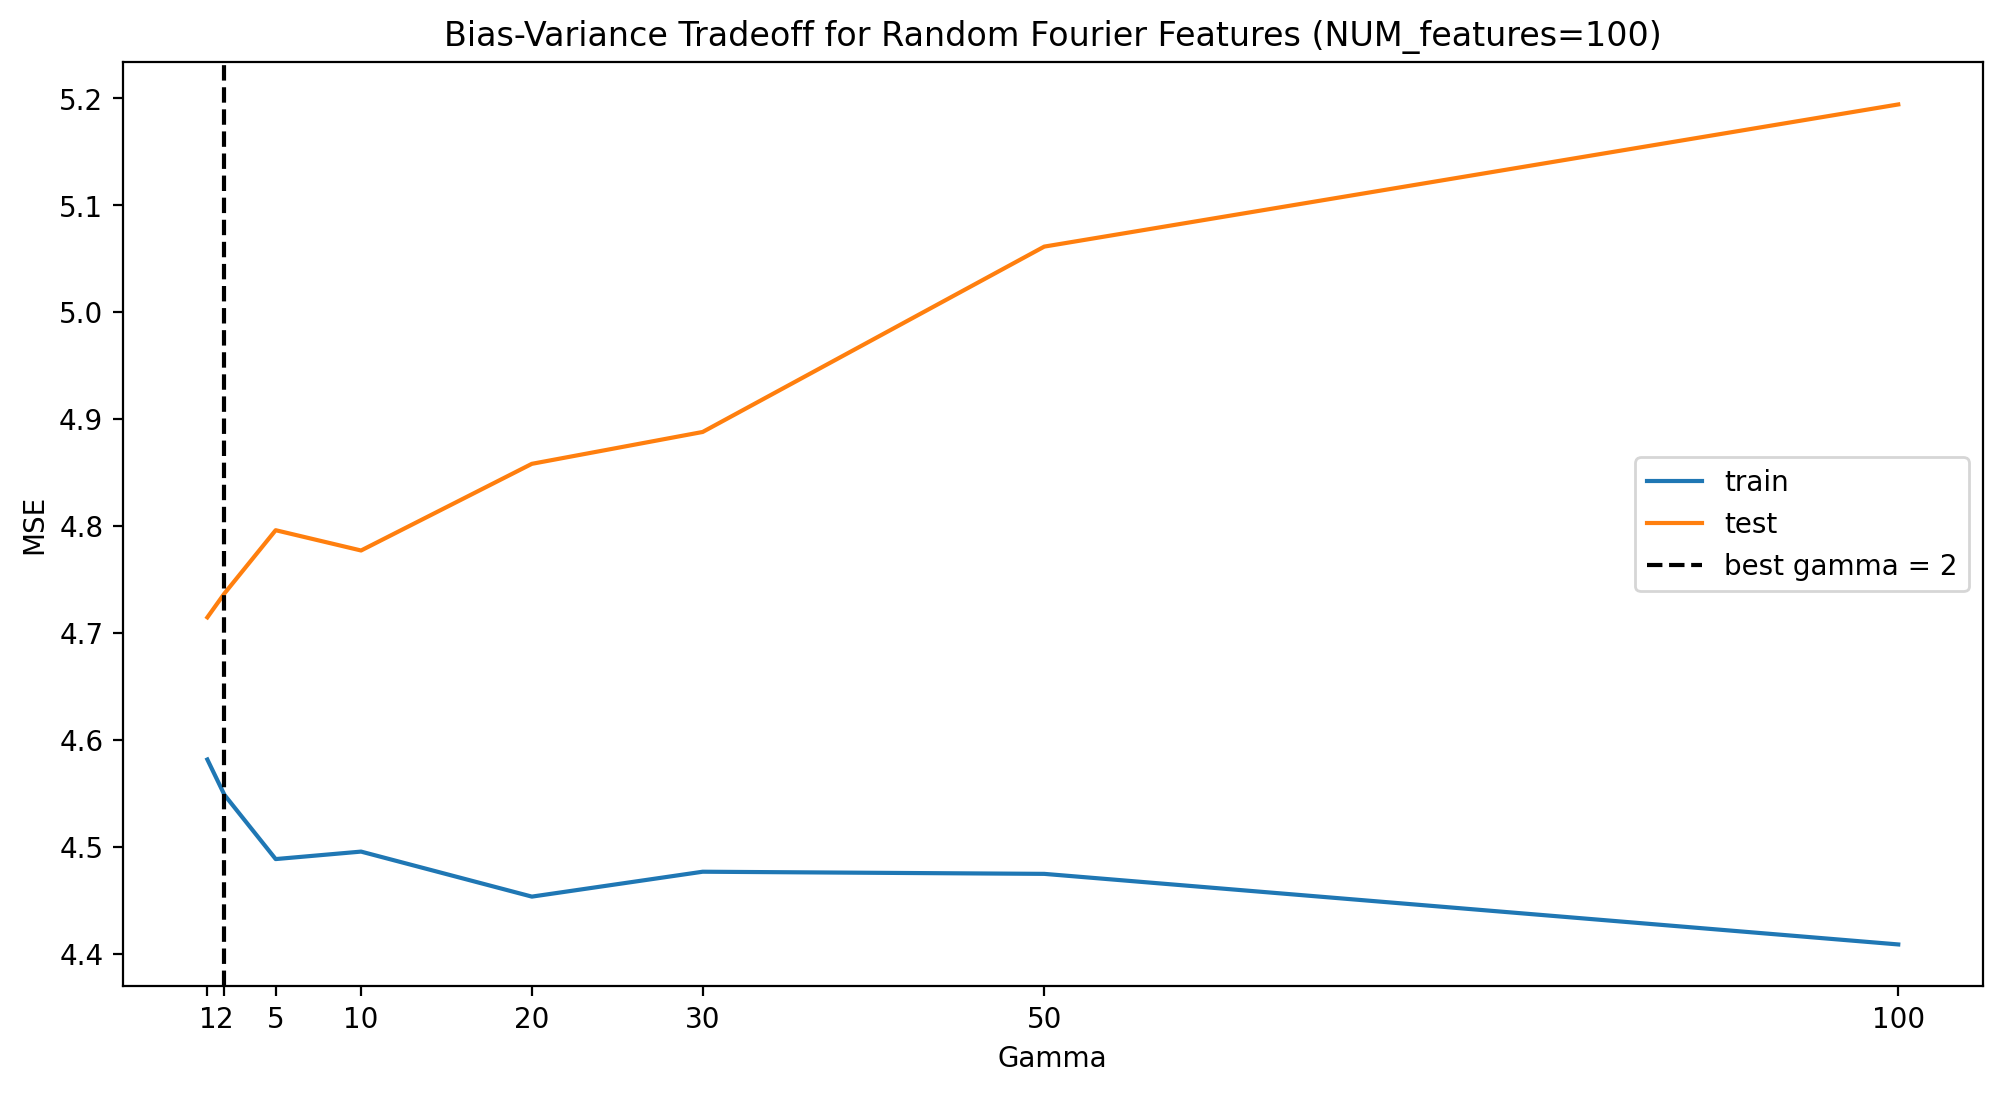

In [56]:
# Bias Variance Tradeoff wrt Gamma plotting

errors_rff_df = pd.DataFrame(errors_rff).T
best_gamma_rff_idx = errors_rff_df['test'].idxmin()
min_error =  errors_rff_df.loc[best_gamma_rff_idx, 'test']   # index of df = gamma - 1
best_gamma_rff = gamma_values[best_gamma_rff_idx]
print(f"Best gamma: {best_gamma_rff}, Min error: {min_error}")

# set figure size
plt.figure(figsize=(12, 6))
plt.plot(errors_rff_df.index, errors_rff_df.train, label='train')
plt.plot(errors_rff_df.index, errors_rff_df.test, label='test')
plt.axvline(best_gamma_rff, color='black', linestyle='--', label=f'best gamma = {best_gamma_rff}')
plt.xticks(gamma_values)
# plt.ylim(4.5, 5.5)      # set y limit - to show the difference between train and test clearly
plt.xlabel('Gamma')
plt.ylabel('MSE')
plt.title('Bias-Variance Tradeoff for Random Fourier Features (NUM_features=100)')
plt.legend()
plt.show()

In [57]:
m = LinearRegression()
m.fit(Xf_norm_train, y_norm_train)

LinearRegression()

In [58]:
m.coef_, m.intercept_

(array([[ 5.06960230e+02,  3.89193258e+13,  5.85988854e+12,
          1.35048550e+12,  7.24040150e+11, -2.63716782e-01,
          2.47429300e+03, -6.87415362e+11,  7.12088393e+12,
          1.16374017e+12,  4.29409253e+06, -3.66514821e+00,
          1.54136835e+12,  8.74770953e+12, -2.49671136e+12,
          2.07943760e+12,  3.10797361e+12,  3.46173686e+13,
          6.91256943e+12,  6.09111499e+12,  5.37068830e+12,
          2.96726654e+11,  2.35736587e+13, -1.82530028e+11,
         -8.21819065e+12, -7.13810407e+12, -2.28400697e+12,
         -7.68427624e+12,  3.60936248e+12,  3.07462503e+12,
         -1.37041806e+13,  4.46494151e+12, -3.01605941e+13,
         -2.14896292e+13, -6.63442406e+11,  9.17744577e+12,
          1.45592007e+13,  2.45241219e+12,  1.17374541e+04,
         -1.19089003e+13, -8.15309135e+12, -2.29416169e+13,
          1.17373031e+13,  2.74890625e+02, -5.85275129e+12,
         -1.68236642e+13, -4.13550922e+12,  9.44158936e+00,
         -2.60569888e+12, -7.71340650e+1

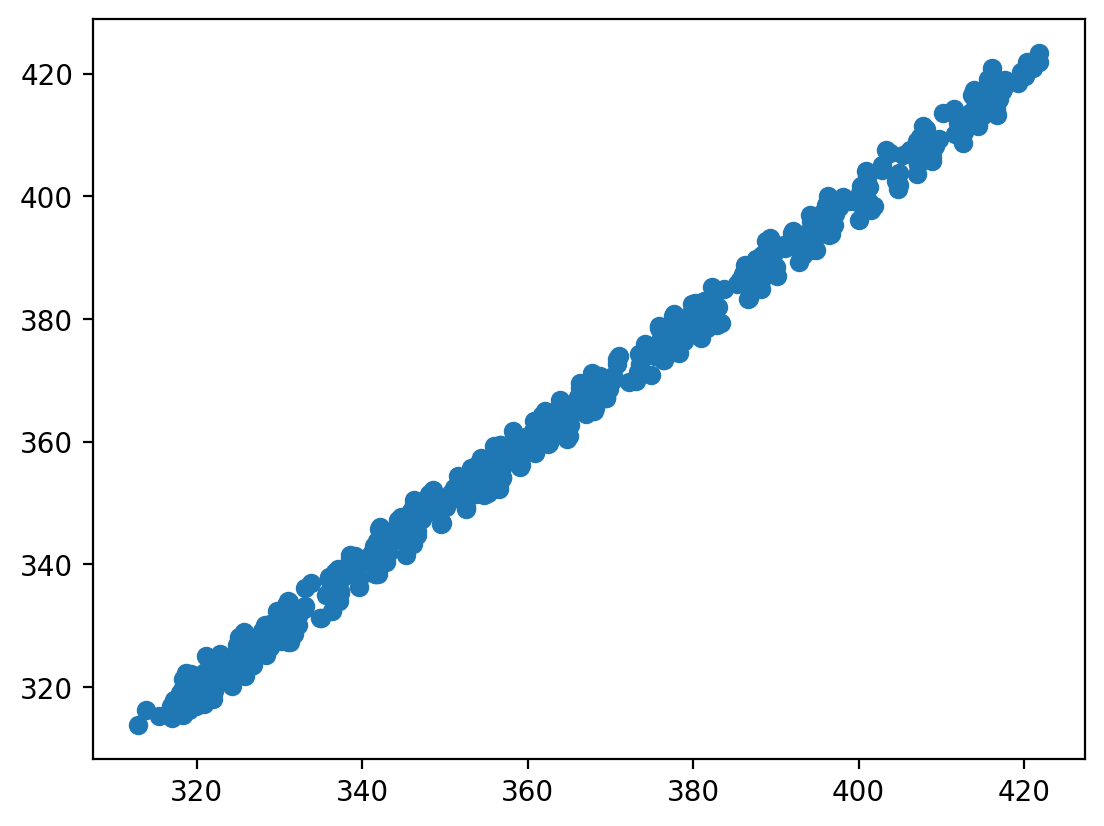

In [59]:
plt.scatter(s2.inverse_transform(m.predict(Xf_norm_train)), s2.inverse_transform(y_norm_train))

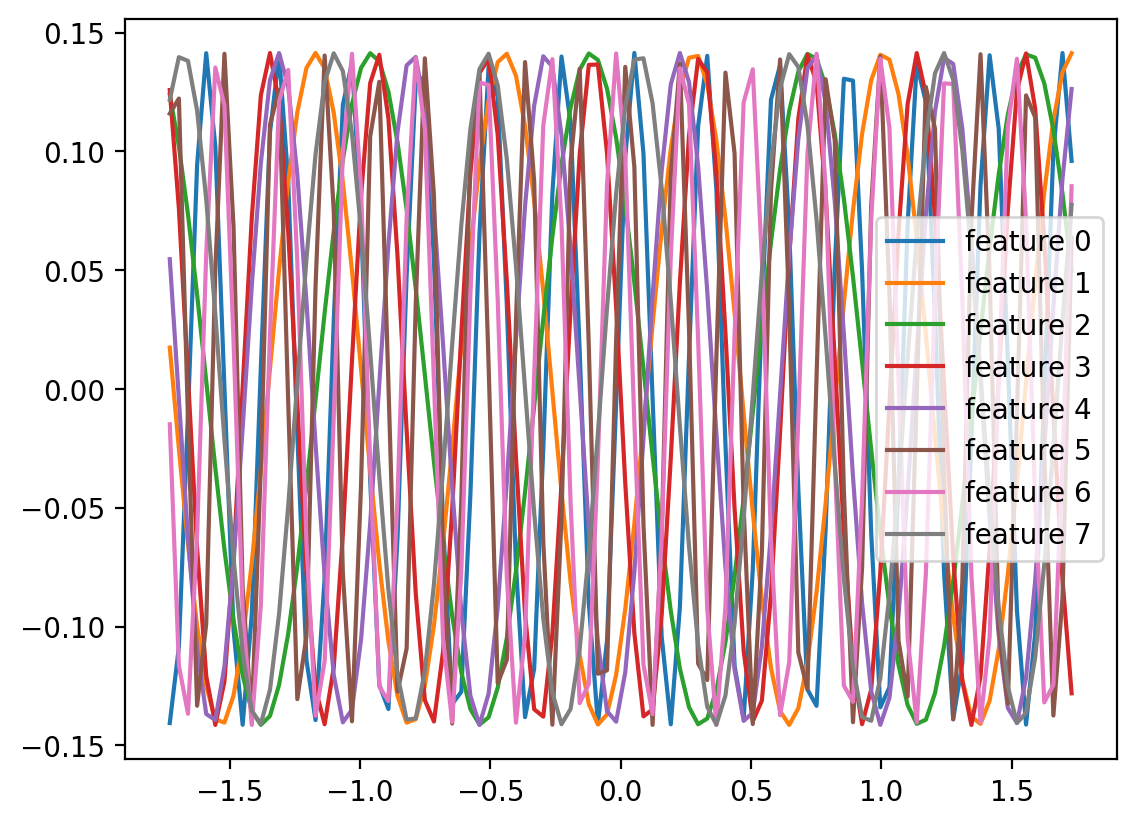

In [60]:
for i in range(2*NUM_features):
    plt.plot(X_lin_1d, X_lin_rff[:, i], label=f'feature {i}')
plt.legend()

In [61]:
pd.DataFrame(Xf_norm_train)

0         1         2         3         4         5         6    
0    0.136819 -0.043600  0.033084 -0.118050 -0.059650  0.048283 -0.052764  \
1    0.125415 -0.138358  0.099597  0.001696  0.013565  0.124357 -0.141405   
2    0.113603  0.075734 -0.110979  0.086962  0.134707  0.046885  0.141341   
3    0.141158 -0.132032  0.085024 -0.037044 -0.017964  0.140744 -0.126358   
4   -0.045200  0.121888 -0.066954 -0.023757  0.078812 -0.140299  0.026098   
..        ...       ...       ...       ...       ...       ...       ...   
526  0.037250  0.011507 -0.014791 -0.140576  0.017374 -0.128329 -0.141147   
527 -0.112852 -0.028758  0.135577  0.133163 -0.138128  0.029940  0.129990   
528  0.130501 -0.138708  0.040963 -0.088108  0.139369  0.041115  0.139948   
529  0.061063 -0.007681 -0.132133  0.089655  0.106339  0.132130  0.005316   
530 -0.053092  0.128657 -0.022882 -0.128871 -0.125254  0.067018  0.063364   

           7         8         9   ...        90        91        92   
0    0.141028  0.119198  0.127338  ...  0.003945  0.117196  0.035825  \
1    0.132175 -0.141158  0.008084  ... -0.006223  0.091838 -0.060559   
2   -0.065376  0.102892  0.068049  ...  0.109605 -0.077608  0.128671   
3    0.119809 -0.139969  0.017151  ...  0.037110  0.096872 -0.072638   
4    0.015388  0.076035  0.042987  ... -0.005919 -0.093708  0.106454   
..        ...       ...       ...  ...       ...       ...       ...   
526  0.129317  0.101119  0.135552  ...  0.101621  0.125797  0.001964   
527 -0.141413  0.088438  0.000602  ... -0.036963 -0.140705 -0.133580   
528 -0.138267 -0.140398 -0.135010  ... -0.137747 -0.134031 -0.141250   
529  0.126963  0.116075 -0.130254  ...  0.051098 -0.101354  0.071741   
530 -0.140217 -0.015250 -0.128137  ...  0.069374 -0.024983  0.137987   

           93        94        95        96        97        98        99  
0    0.054965 -0.140217 -0.132301 -0.000754 -0.036879 -0.114977 -0.044124  
1    0.140948  0.134071 -0.079933 -0.058772 -0.080682 -0.100590 -0.126280  
2    0.005091  0.015024 -0.062057  0.039211  0.076210 -0.032006 -0.125198  
3    0.137137  0.138181 -0.082246 -0.069945 -0.079370 -0.083459 -0.135647  
4   -0.062621 -0.031080 -0.069554  0.002066  0.072144  0.035252 -0.073491  
..        ...       ...       ...       ...       ...       ...       ...  
526 -0.001851 -0.130039 -0.129643 -0.031865 -0.040706 -0.073813  0.018788  
527 -0.037492  0.122743  0.054121 -0.105916 -0.130054 -0.087806  0.141417  
528  0.138213 -0.033786 -0.119260 -0.117543  0.036299 -0.121394 -0.094026  
529  0.055116 -0.114573  0.004001  0.098825 -0.115988  0.061461 -0.140051  
530 -0.139318 -0.099034 -0.032418  0.132504 -0.102951  0.081138  0.111772  

[531 rows x 100 columns]

In [62]:
Xf_norm_train.mean(axis=0), Xf_norm_train.std(axis=0)

(array([-4.01885305e-03, -4.61920773e-03,  2.83731916e-03,  5.79910742e-03,
        -2.21773324e-03, -2.16004643e-03, -1.94075153e-03, -2.51868920e-03,
         1.96198784e-02, -1.82803278e-03, -1.30522024e-03, -3.07663424e-03,
        -1.80751855e-02,  1.75594345e-04,  2.71208802e-03,  2.78155342e-03,
         2.82633672e-02,  5.96430451e-03, -6.34045907e-04, -9.03006447e-04,
        -4.75070459e-03, -2.04327093e-03, -1.58713056e-03, -2.91620203e-03,
        -5.43135808e-03,  9.59753840e-03, -2.03417380e-03, -7.31620114e-03,
         4.35071737e-03,  4.20698195e-03, -1.06095151e-02,  4.23290463e-03,
         9.70273605e-03, -7.99862607e-03,  8.16348469e-04,  1.38789189e-01,
         1.14760313e-03,  8.40571468e-03,  1.00391864e-03, -1.73225168e-03,
         1.53383732e-02,  5.48517675e-03, -5.73704834e-03,  5.64421382e-03,
        -7.43041028e-02, -2.03611448e-03, -1.13548725e-03, -2.63282429e-03,
         1.16333379e-03,  8.40972655e-05,  7.23519841e-03, -6.82977188e-03,
         5.2

In [63]:
X_lin_rff.mean(axis=0), X_lin_rff.std(axis=0)

(array([ 8.22326289e-04, -3.99036552e-03,  3.31299927e-03, -9.58319830e-05,
        -3.56712903e-03,  5.43466928e-04, -2.40222931e-03, -2.20516353e-04,
         1.72513318e-02, -2.16892744e-03, -6.08258756e-04, -3.99407444e-04,
        -1.64285633e-02, -9.67991631e-04,  1.17906735e-03,  4.58742723e-03,
         2.71788391e-02,  5.60808994e-04, -1.71168242e-03, -3.68932495e-04,
         1.55965134e-03,  5.07999230e-05, -1.77942787e-03, -9.74445867e-04,
        -1.08435614e-04,  7.79213067e-03, -3.55989385e-03, -2.65919769e-03,
         3.89933660e-03,  5.51320173e-03, -7.39071741e-03,  5.32481132e-03,
         6.27838253e-03, -5.53656780e-03,  2.70786364e-03,  1.38768873e-01,
        -2.81097191e-03,  8.40092357e-03,  5.78133687e-04,  1.11742221e-04,
         1.44985068e-02, -3.53077029e-05, -2.66163403e-03,  1.98006291e-03,
        -7.34495126e-02, -7.15600287e-05, -5.19192184e-04,  2.60100113e-03,
        -5.29573393e-04,  1.38555579e-03,  6.01726611e-03, -6.87174650e-03,
        -2.1

### Extrapolation using Gaussian Process

In [64]:
X_norm_train = X_norm[:int(len(X_norm)*0.7)]
X_norm_test = X_norm[int(len(X_norm)*0.7):]

y_norm_train = y_norm[:int(len(y_norm)*0.7)]
y_norm_test = y_norm[int(len(y_norm)*0.7):]

X_train = X[:int(len(X)*0.7)]
X_test = X[int(len(X)*0.7):]

y_train = y[:int(len(y)*0.7)]
y_test = y[int(len(y)*0.7):]

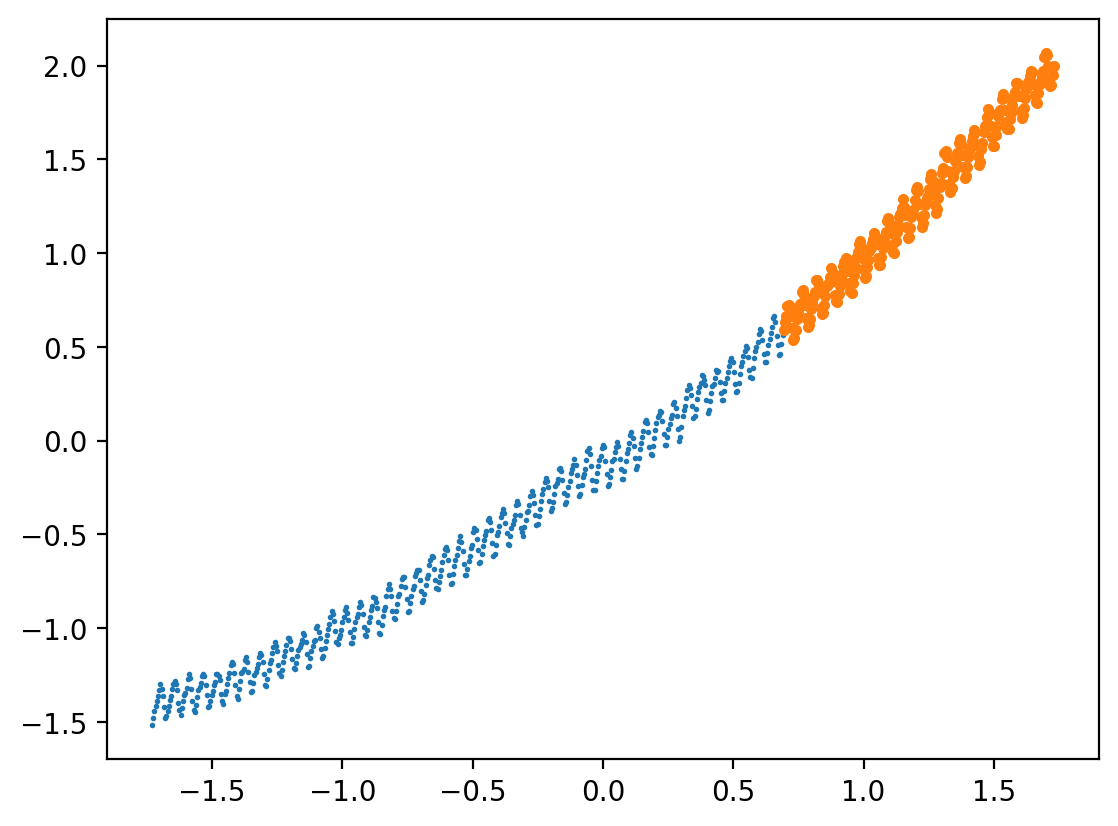

In [65]:
plt.plot(X_norm_train, y_norm_train, 'o', label='train',markersize=1)
plt.plot(X_norm_test, y_norm_test, 'o', label='test', ms=3)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


{'train': 0.0013462288667833444, 'test': 84.95456694866307}

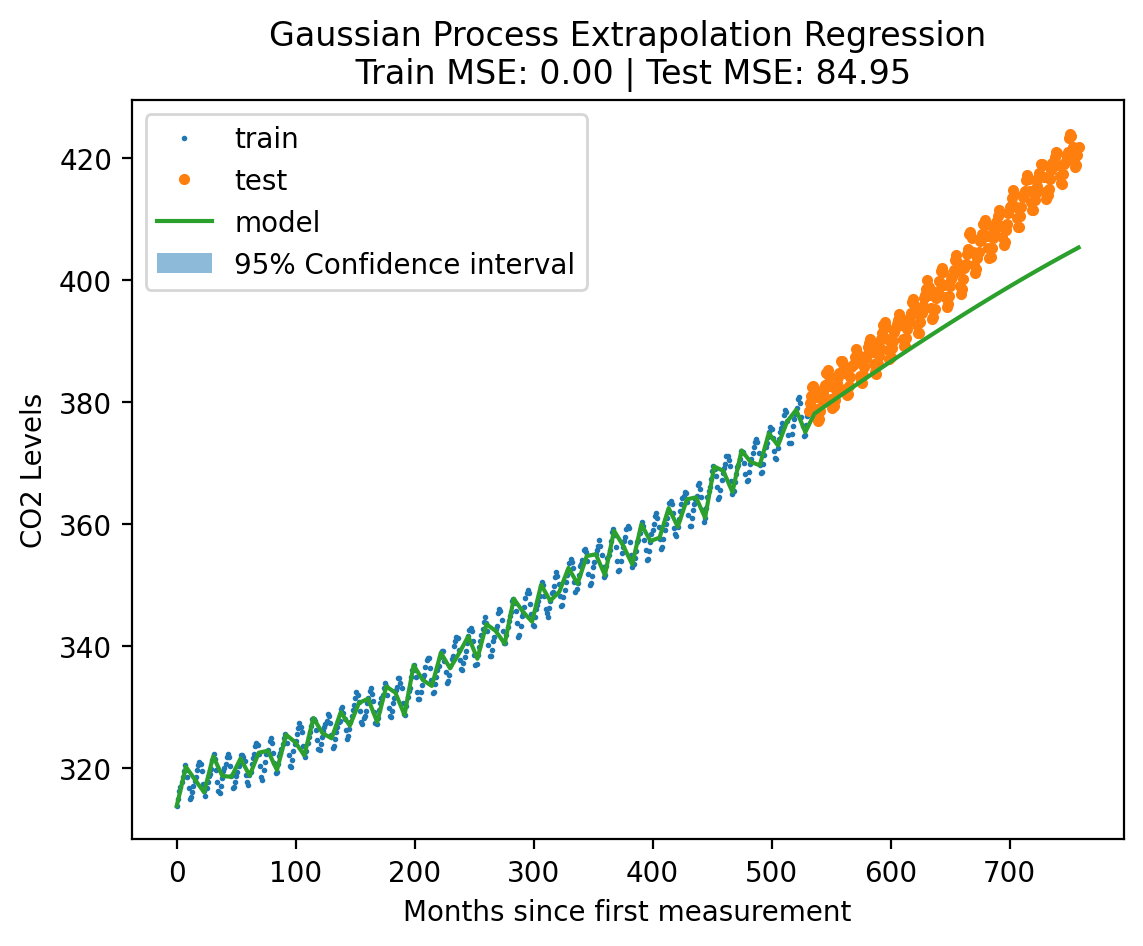

In [66]:
plot_fit_gp(X_norm_train, y_norm_train, X_norm_test, y_norm_test, X_lin_1d, "Gaussian Process Extrapolation Regression")

### Before this...

# Dataset 1: Sine wave with noise

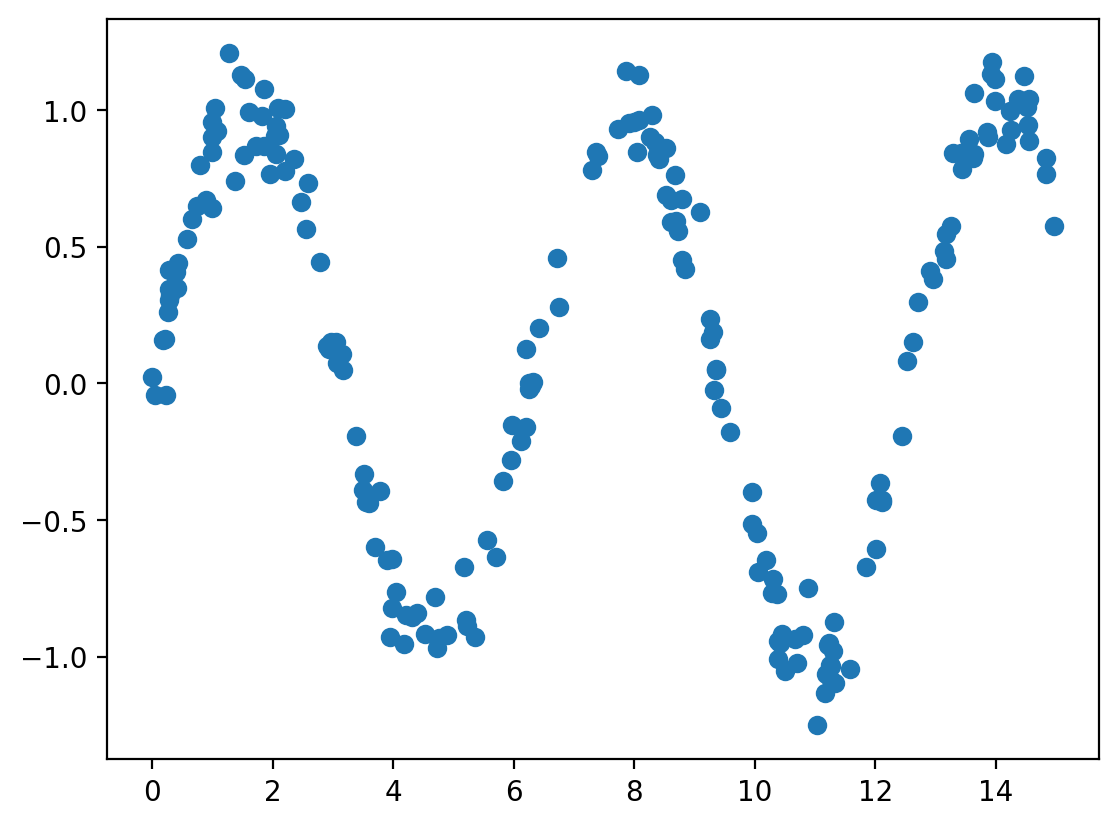

In [67]:
# Generate some data
rng = np.random.RandomState(1)
x = 15 * rng.rand(200)
y = np.sin(x) + 0.1 * rng.randn(200)
df = pd.DataFrame({'x': x, 'y': y})

# plot the data
plt.scatter(df.x, df.y)
plt.show()

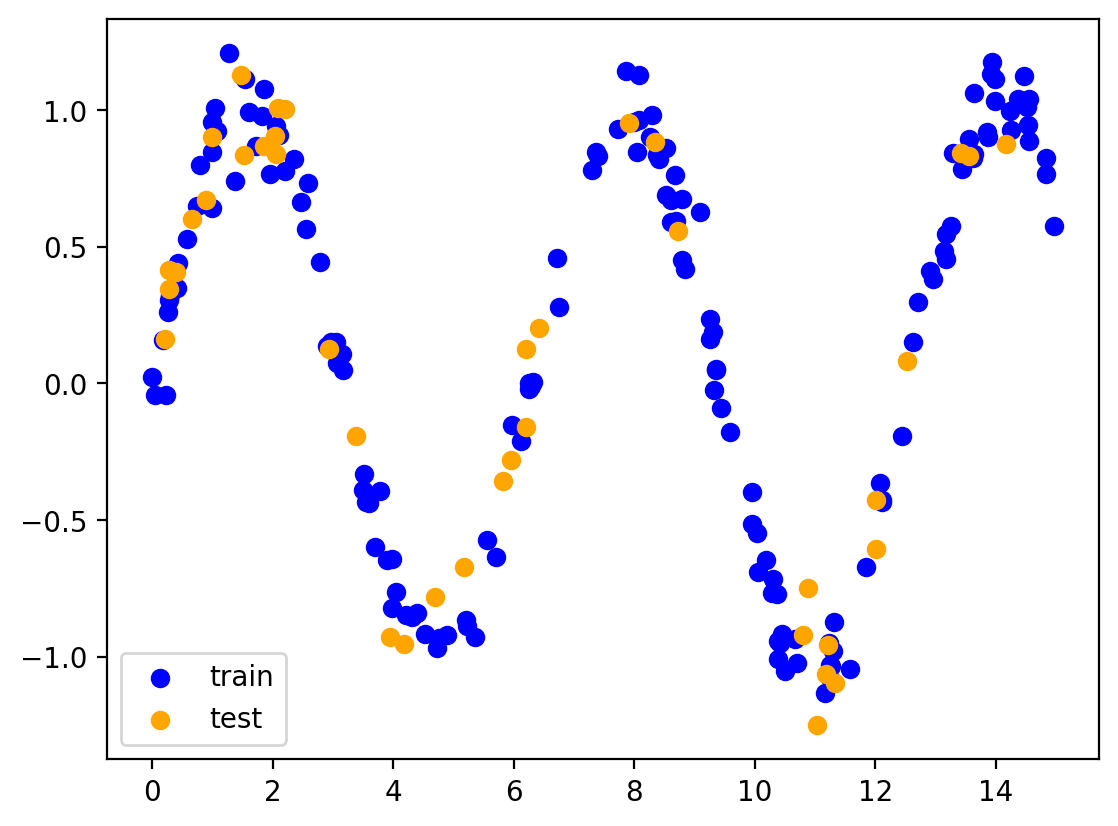

In [68]:
# Train test split
train = df.sample(frac=0.8, random_state=1)
test = df.drop(train.index)

plt.scatter(train.x, train.y, color='blue', label='train')
plt.scatter(test.x, test.y, color='orange', label='test')
plt.legend()
plt.show()

In [69]:
def plot_predictions(train, test, yhat_train, yhat_test):
        
    # add yhat_train to train and yhat_test to test
    train['yhat'] = yhat_train
    test['yhat'] = yhat_test

    # sort train and test by x
    train = train.sort_values(by='x')
    test = test.sort_values(by='x')

    # Train and test error
    train_rmse = np.sqrt(np.mean((train.yhat - train.y)**2))
    test_rmse = np.sqrt(np.mean((test.yhat - test.y)**2))

    plt.scatter(train.x, train.y, color='blue', label='train')
    plt.scatter(test.x, test.y, color='orange', label='test')
    plt.plot(train.x, train.yhat, color='red', label='train prediction')
    plt.plot(test.x, test.yhat, color='green', label='test prediction')
    plt.title('Train RMSE: {:.3f}, Test RMSE: {:.3f}'.format(train_rmse, test_rmse))
    plt.legend()
    plt.show()

    return train_rmse, test_rmse

In [70]:
# Hyperparameter tuning using grid search and showing bias variance tradeoff
def hyperparameter_tuning(params, train, test, model):
    train_rmse = []
    test_rmse = []

    for d in params:
        yhat_train, yhat_test = model(d, train, test)
        train_rmse.append(np.sqrt(np.mean((yhat_train - train.y)**2)))
        test_rmse.append(np.sqrt(np.mean((yhat_test - test.y)**2)))

    plt.plot(params, train_rmse, label='train')
    plt.plot(params, test_rmse, label='test')
    plt.xlabel('params')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

    optimal_param = params[np.argmin(test_rmse)]

    return optimal_param

In [71]:
rmse_dict = {}

### Model 1: MLP

In [72]:
# use sk-learn for MLP
mlp_model = MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter = 10000)
mlp_model.fit(np.array(train.x).reshape(-1, 1), train.y)

MLPRegressor(hidden_layer_sizes=[128, 256, 512, 256, 128], max_iter=10000)

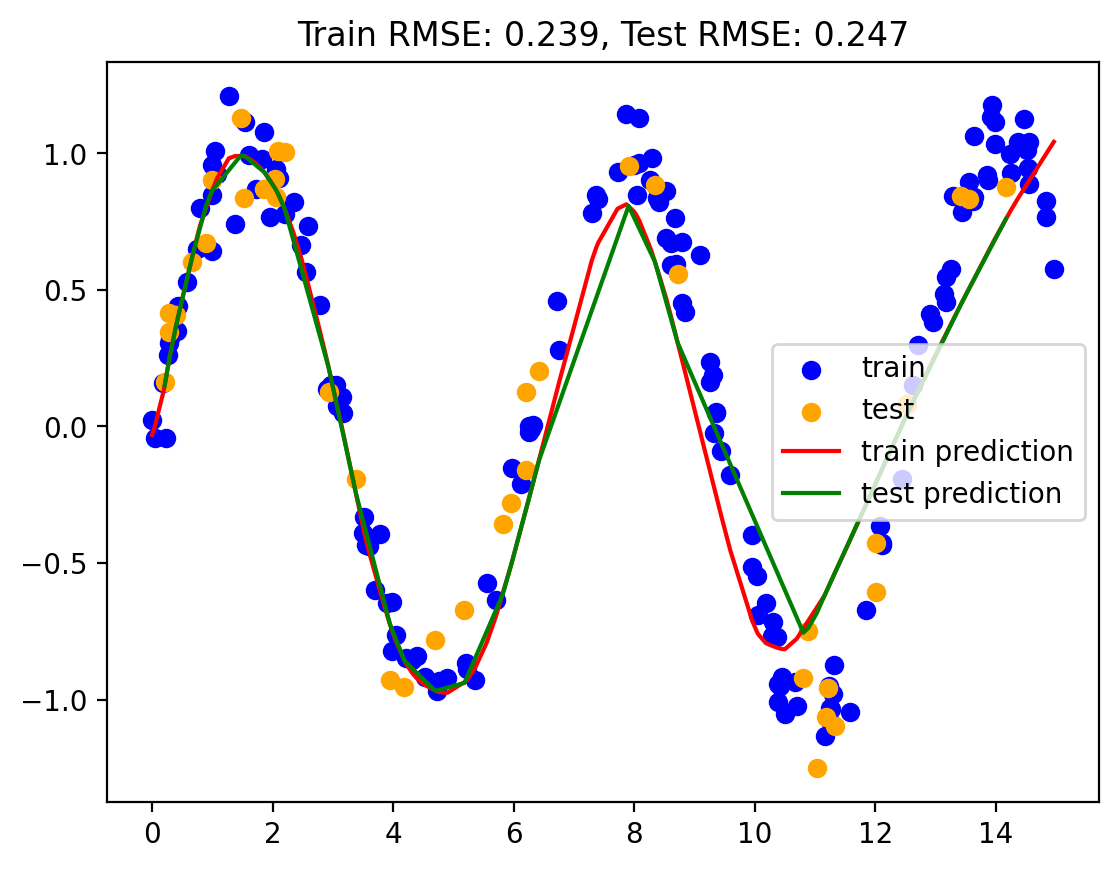

In [73]:
yhat_train = mlp_model.predict(np.array(train.x).reshape(-1, 1))
yhat_test = mlp_model.predict(np.array(test.x).reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['MLP'] = (train_rmse, test_rmse)

### Model 2: Vanilla Linear Regression

In [74]:
lr1 = LinearRegression()
lr1.fit(np.array(train.x).reshape(-1, 1), train.y)

LinearRegression()

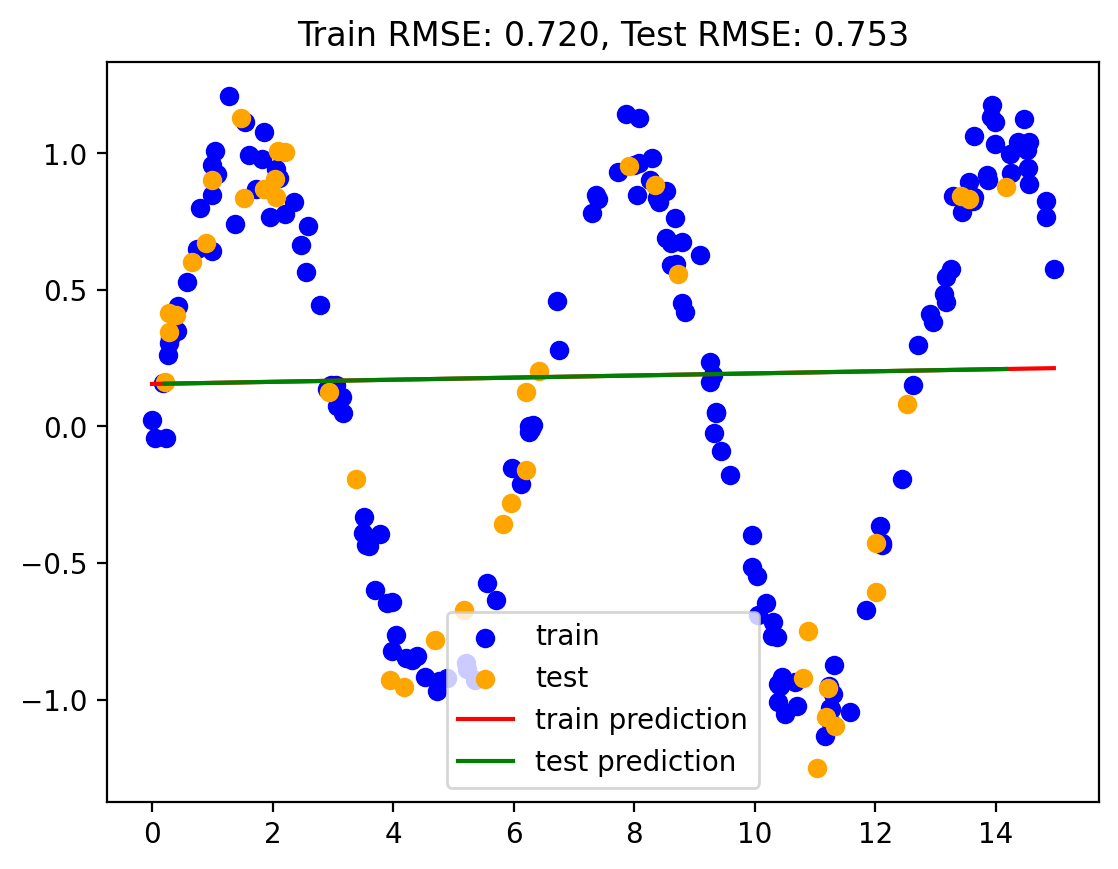

In [75]:
yhat_train = lr1.predict(np.array(train.x).reshape(-1, 1))
yhat_test = lr1.predict(np.array(test.x).reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Vanilla LR'] = (train_rmse, test_rmse)

### Model 3: Polynomial regression with degree d

In [76]:
def poly_regression(d, train, test):
    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    
    X_train = pf.fit_transform(train.x.values.reshape(-1, 1))
    X_test = pf.fit_transform(test.x.values.reshape(-1, 1))
    
    lr.fit(X_train, train.y)
    
    yhat_train = lr.predict(X_train)
    yhat_test = lr.predict(X_test)

    return yhat_train, yhat_test

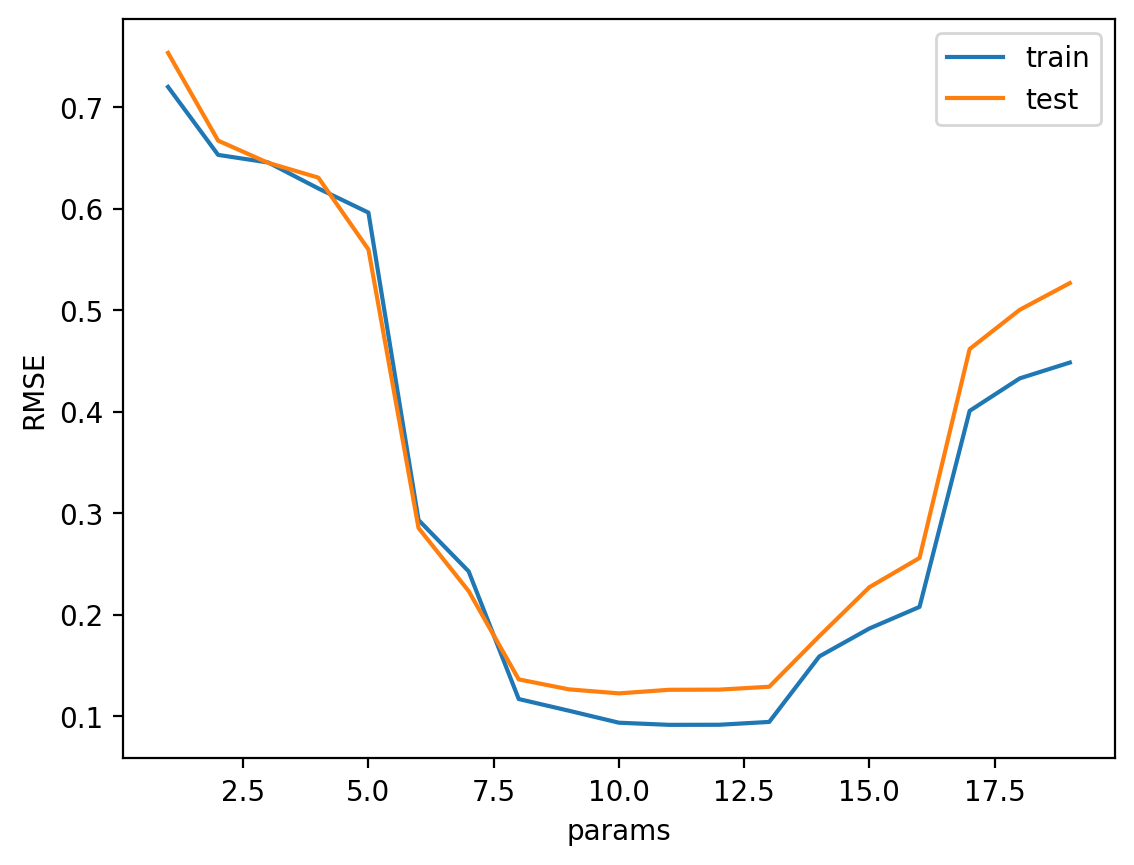

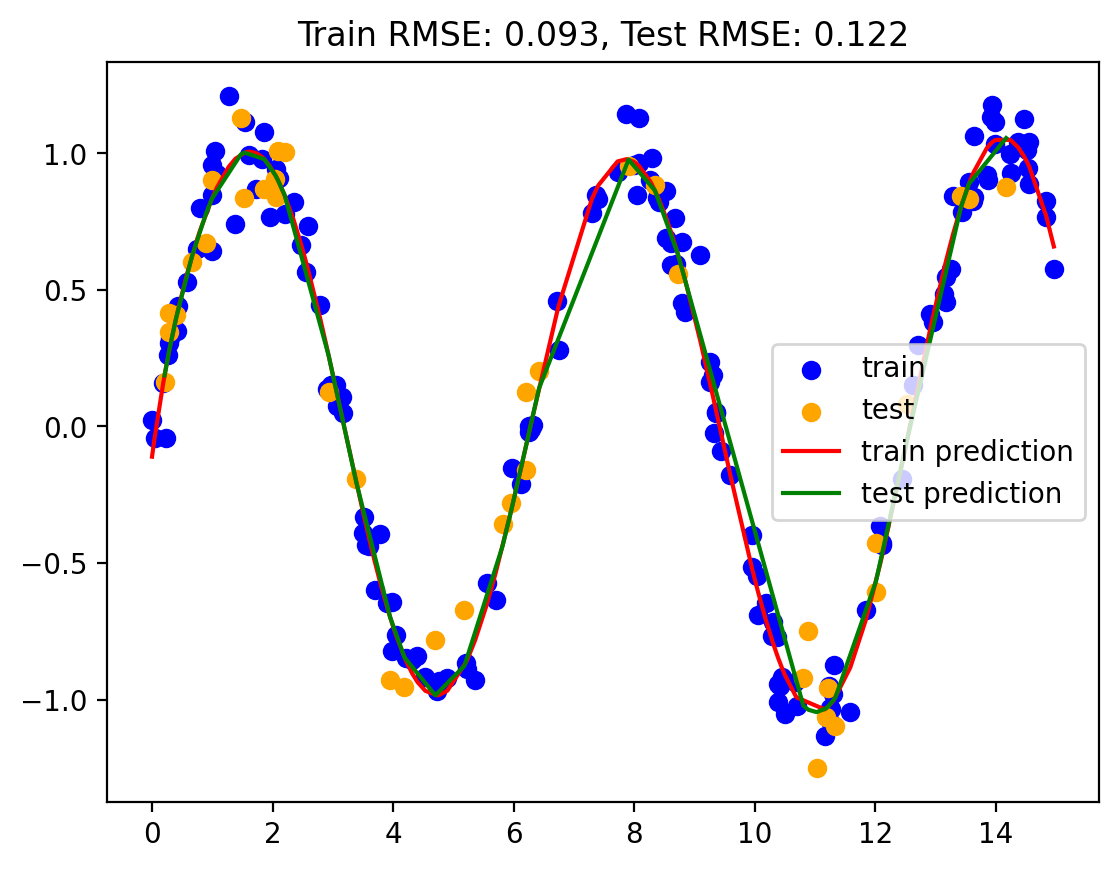

Best degree:  10


In [77]:
# Hyperparameter tuning using grid search and showing bias variance tradeoff
degrees = range(1, 20)
best_degree = hyperparameter_tuning(degrees, train, test, poly_regression)
yhat_train, yhat_test = poly_regression(best_degree, train, test)
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Polynomial Regression'] = (train_rmse, test_rmse)
print("Best degree: ", best_degree)

### Model 4: Linear regression with sine and cosine basis functions

In [78]:
def sine_basis_regression(num_basis, train, test):
    lr = LinearRegression()
    for i in range(1, num_basis+1):
        train[f"sine_{i}"] = np.sin(i*train.x)
        train[f"cosine_{i}"] = np.cos(i*train.x)
        test[f"sine_{i}"] = np.sin(i*test.x)
        test[f"cosine_{i}"] = np.cos(i*test.x)
    
    X_train = train.drop(['y'], axis=1)
    X_test = test.drop(['y'], axis=1)
    
    lr.fit(X_train, train.y)

    yhat_train = lr.predict(X_train)
    yhat_test = lr.predict(X_test)

    return yhat_train, yhat_test

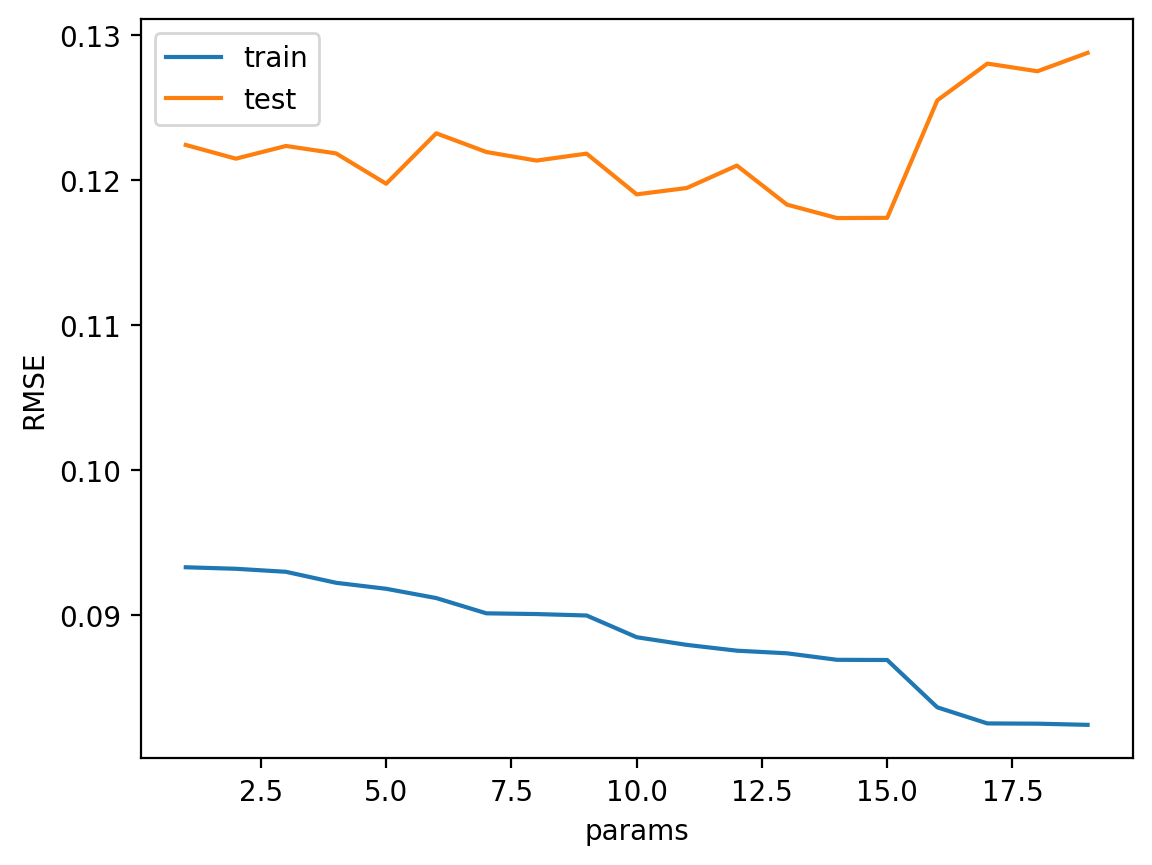

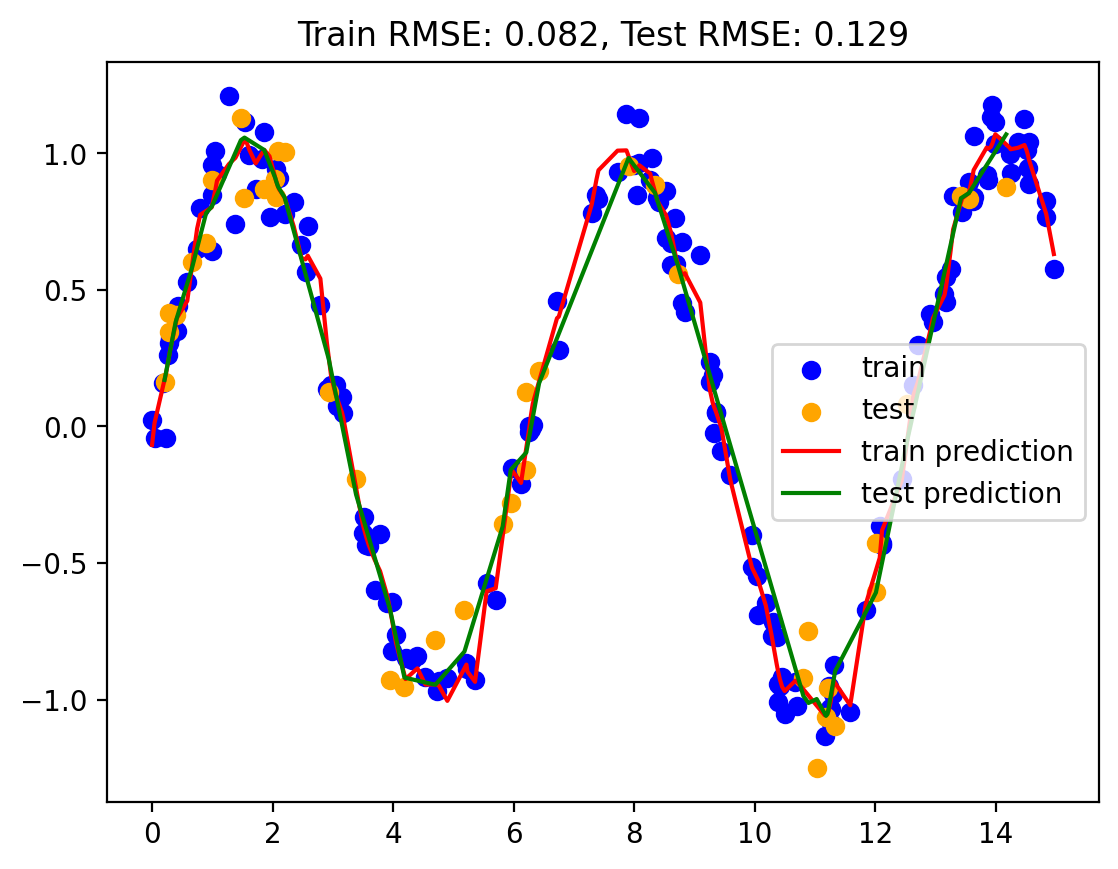

Best number of basis:  14


In [79]:
basis = range(1, 20)
best_num_basis = hyperparameter_tuning(basis, train, test, sine_basis_regression)
yhat_train, yhat_test = sine_basis_regression(best_num_basis, train, test)
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Sine Basis Regression'] = (train_rmse, test_rmse)
print("Best number of basis: ", best_num_basis)

### Model 5: Linear regression with Gaussian basis functions

In [80]:
# Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Gaussian-basis-functions

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """
    Uniformly spaced Gaussian features for one-dimensional input
    
    Constructor with N centers and width_factor as hyperparameters
    N comes from the number of basis functions
    width_factor is the width of each basis function
    """
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

Best number of basis:  13


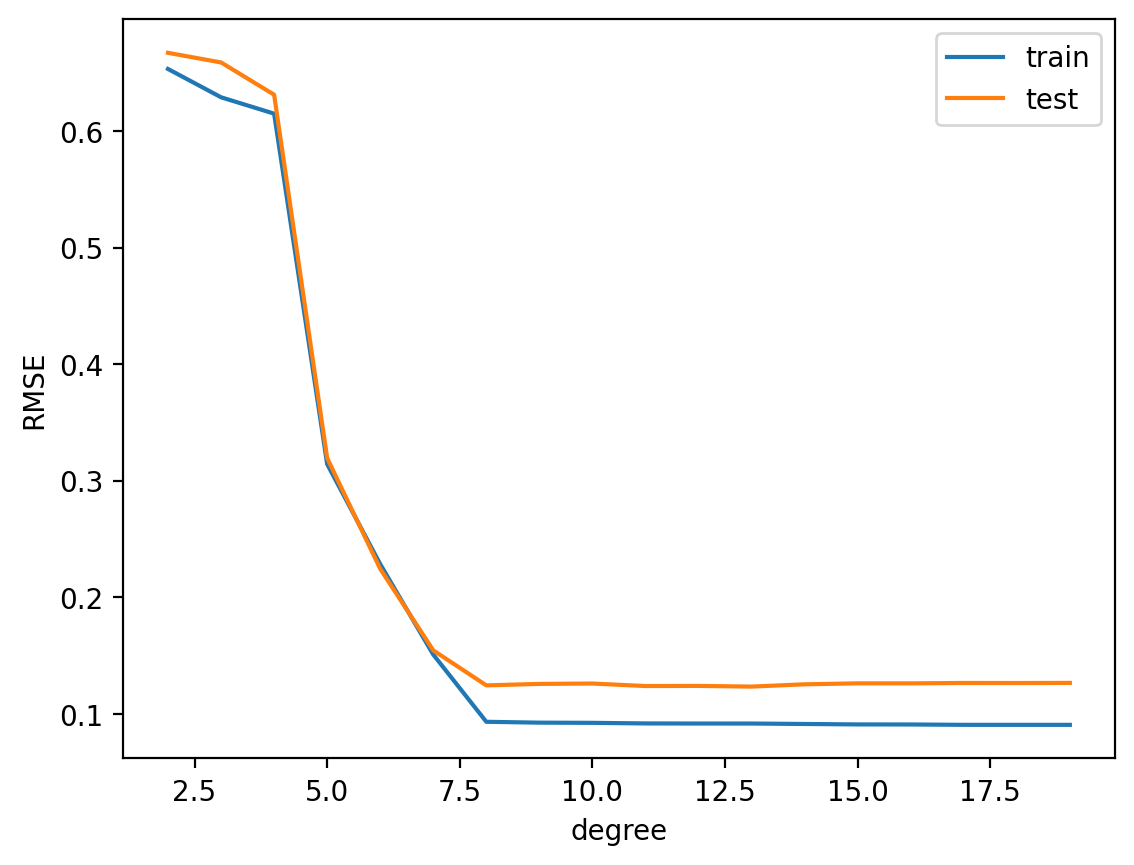

In [81]:
# Hyperparameter tuning
basis = range(2, 20)

train_rmse = []
test_rmse = []
for d in basis:
    model = make_pipeline(GaussianFeatures(d), LinearRegression())
    model.fit(np.array(train.x).reshape(-1, 1), train.y)
    yhat_train = model.predict(np.array(train.x).reshape(-1, 1))
    yhat_test = model.predict(np.array(test.x).reshape(-1, 1))
    train_rmse.append(np.sqrt(np.mean((yhat_train - train.y)**2)))
    test_rmse.append(np.sqrt(np.mean((yhat_test - test.y)**2)))

best_num_basis = basis[np.argmin(test_rmse)]
print("Best number of basis: ", best_num_basis)
plt.plot(basis, train_rmse, label='train')
plt.plot(basis, test_rmse, label='test')
plt.xlabel('degree')
plt.ylabel('RMSE')
plt.legend()
plt.show()

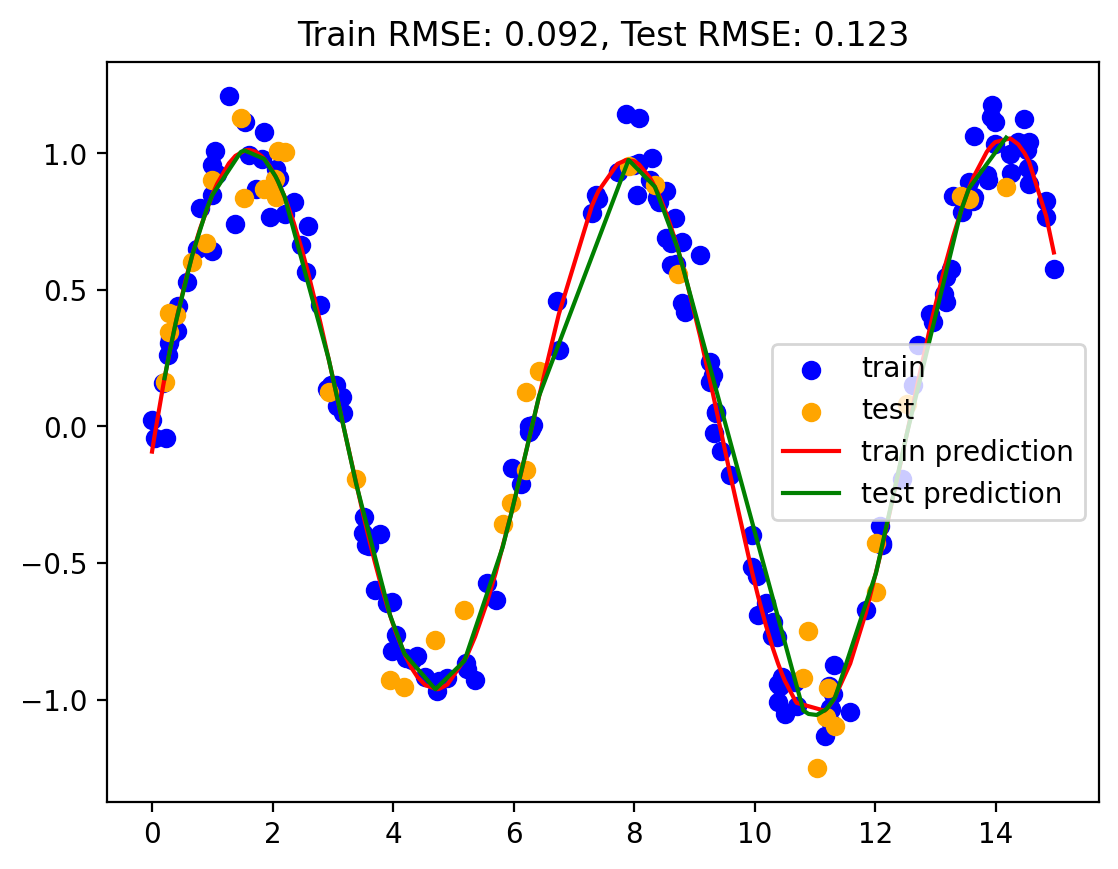

In [82]:
gauss_model = make_pipeline(GaussianFeatures(best_num_basis), LinearRegression())
gauss_model.fit(np.array(train.x).reshape(-1, 1), train.y)
yhat_train = gauss_model.predict(train.x.values.reshape(-1, 1))
yhat_test = gauss_model.predict(test.x.values.reshape(-1, 1))
train_rmse, test_rmse = plot_predictions(train, test, yhat_train, yhat_test)
rmse_dict['Gaussian Basis Regression'] = (train_rmse, test_rmse)

#### Plotting rmse using different variants of linear regression

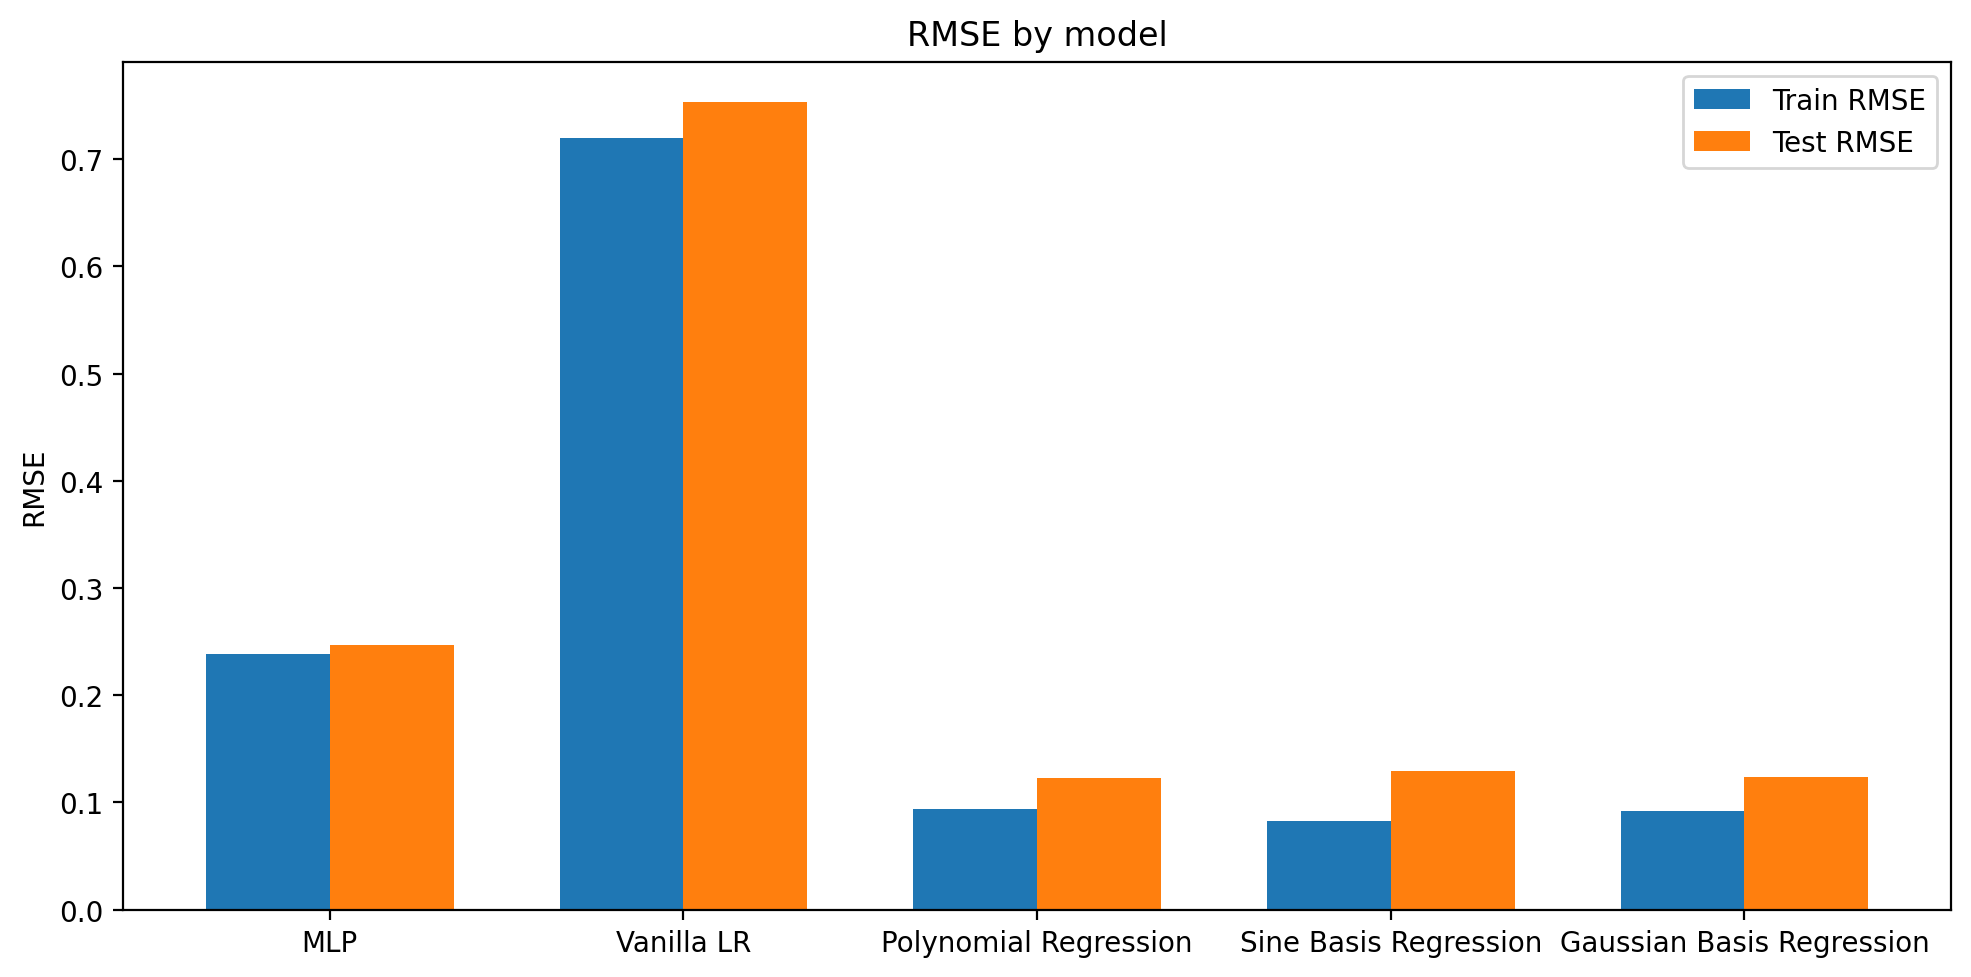

In [83]:
# create a bar plot of train and test RMSE

train_rmse = [rmse_dict[key][0] for key in rmse_dict.keys()]
test_rmse = [rmse_dict[key][1] for key in rmse_dict.keys()]
labels = [key for key in rmse_dict.keys()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE')
rects2 = ax.bar(x + width/2, test_rmse, width, label='Test RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

# Dataset 2: CO2 Dataset

In [84]:
df

x         y
0     6.255330 -0.020070
1    10.804867 -0.920032
2     0.001716  0.024965
3     4.534989 -0.916051
4     2.201338  0.776696
..         ...       ...
195  13.979581  1.115462
196   0.209274  0.163526
197   3.515431 -0.332839
198   9.251675  0.161240
199  14.235245  0.996049

[200 rows x 2 columns]

In [85]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

KeyError: "None of [Index(['year', 'month'], dtype='object')] are in the [columns]"

In [ ]:
df

x         y
0     6.255330 -0.020070
1    10.804867 -0.920032
2     0.001716  0.024965
3     4.534989 -0.916051
4     2.201338  0.776696
..         ...       ...
195  13.979581  1.115462
196   0.209274  0.163526
197   3.515431 -0.332839
198   9.251675  0.161240
199  14.235245  0.996049

[200 rows x 2 columns]

In [ ]:
df.average.plot()

AttributeError: 'DataFrame' object has no attribute 'average'

In [ ]:
train_cutoff = 2000
train = df[df.year < train_cutoff]
test = df[df.year >= train_cutoff]
df.average.plot()

train.average.plot(color='blue')
test.average.plot(color='orange')

len(train), len(test)

In [ ]:
months_from_start = range(len(df))
months_from_start = np.array(months_from_start).reshape(-1, 1)

In [ ]:
# use sk-learn for MLP

mlp_model = MLPRegressor(hidden_layer_sizes=[512, 512, 512, 512, 512], max_iter = 5000)
mlp_model.fit(months_from_start[:len(train)], train.average.values)

In [ ]:
yhat_train = mlp_model.predict(months_from_start[:len(train)])
yhat_test = mlp_model.predict(months_from_start[len(train):])

yhat_train = pd.Series(yhat_train, index=train.index)
yhat_test = pd.Series(yhat_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
# normalize data

train_scaled = (train - train.mean()) / train.std()
test_scaled = (test - test.mean()) / test.std()
months_from_start_scaled = (months_from_start - months_from_start.mean()) / months_from_start.std()

# train_scaled = (train - train.mean()) / train.std()
# test_scaled = (test - test.mean()) / test.std()
# months_from_start_scaled = (months_from_start - months_from_start.mean()) / months_from_start.std()

mlp_model = MLPRegressor(hidden_layer_sizes=512, max_iter = 1000)
mlp_model.fit(months_from_start_scaled[:len(train)], train_scaled.average.values)

yhat_train = mlp_model.predict(months_from_start_scaled[:len(train)])
yhat_test = mlp_model.predict(months_from_start_scaled[len(train):])

yhat_train_scaled = pd.Series(yhat_train, index=train.index)
yhat_test_scaled = pd.Series(yhat_test, index=test.index)

yhat_train = yhat_train_scaled * train.std() + train.mean()
# yhat_test = yhat_test_scaled * test.std() + test.mean()


df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

### Model 2: Vanilla Linear Regression

In [ ]:
lr1 = LinearRegression()
lr1.fit(months_from_start[:len(train)], train.average.values)
yhat1_test = lr1.predict(months_from_start[len(train):])
yhat1_train = lr1.predict(months_from_start[:len(train)])

yhat_train = pd.Series(yhat1_train, index=train.index)
yhat_test = pd.Series(yhat1_test, index=test.index)

df.average.plot()
yhat_train.plot()
yhat_test.plot()

# Train error
train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

### Model 3: Polynomial regression with degree d

In [ ]:
def poly_regression(d, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    pf = PolynomialFeatures(degree=d)
    X_train = pf.fit_transform(months_from_start[:len(train)])
    X_test = pf.fit_transform(months_from_start[len(train):])
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    df.average.plot()
    yhat_train.plot()
    yhat_test.plot()
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_regression(2, train, test)

### Model 4: Linear Regression with sine and cosine basis functions

In [ ]:
### Adding sine and cosine terms
def sine_cosine_features(X, n):
    """
    X: array of shape (n_samples, 1)
    n: number of sine and cosine features to add
    """
    for i in range(1, n+1):
        X = np.hstack([X, np.sin(i*X), np.cos(i*X)])
    return X

In [ ]:
X = np.linspace(-1, 1, 100).reshape(-1, 1)

In [ ]:
_ = plt.plot(X, sine_cosine_features(X, 0))

### Model 5: Gaussian basis functions

### Model 6: Linear Regression with polynomial and sine/cosine basis functions

In [ ]:
def poly_sine_cosine_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = sine_cosine_features(months_from_start[:len(train)], n)
    
    X_test = sine_cosine_features(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_sine_cosine_regression(6, train, test)

### Model 7: Random Fourier Features

In [ ]:
def rff_featurise(X, n_components=100):
    # Random Fourier Features
    # https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
    from sklearn.kernel_approximation import RBFSampler
    rbf_feature = RBFSampler(gamma=1, n_components=n_components, random_state=1)
    X_features = rbf_feature.fit_transform(X)
    return X_features

In [ ]:
def poly_rff_regression(n, train, test):
    months_from_start = range(len(df))
    months_from_start = np.array(months_from_start).reshape(-1, 1)

    lr = LinearRegression()
    
    X_train = rff_featurise(months_from_start[:len(train)], n)
    
    X_test = rff_featurise(months_from_start[len(train):], n)
    print(X_train.shape, X_test.shape)
    
    lr.fit(X_train, train.average.values)
    
    yhat_test = lr.predict(X_test)
    yhat_train = lr.predict(X_train)
    

    yhat_train = pd.Series(yhat_train, index=train.index)
    yhat_test = pd.Series(yhat_test, index=test.index)

    
    yhat_train.plot(alpha=0.2, lw=4)
    yhat_test.plot(alpha=0.2, lw=4)
    df.average.plot(color='k', lw=1)
    
    # Train error
    train_rmse = np.sqrt(np.mean((yhat_train - train.average)**2))
    test_rmse = np.sqrt(np.mean((yhat_test - test.average)**2))
    plt.title('Train RMSE: {:.2f}, Test RMSE: {:.2f}'.format(train_rmse, test_rmse))

In [ ]:
poly_rff_regression(440, train, test)